<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2022/blob/prac-bayesian-deep-learning/Bayesian_Deep_Learning_Prac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Deep Learning Practical

<img src="https://i.imgur.com/btStvUL.png" width="90%" />



<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2022/blob/main/Indaba_2022_Prac_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> <font color='red'>`[TODO: Change colab link to point to prac.]`</font>

© Deep Learning Indaba 2022. Apache License 2.0.

**Authors:**

Javier Antorán

<font color='red'>`Please add yourself here`</font>.


**Introduction:** 

Bayesian inference provides us with the tools to update our beliefs consistently when we observe data. Compared to the more common loss minimisation approach to learning, Bayesian methods offer us calibrated uncertainty estimates, resistance to overfitting, and even approaches to select hyper-parameters without a validation set. 🚀In this prac we will learn to do all of these things!🚀



**Aims/Learning Objectives:**


* Understand the tradeoffs of Maximum Likelihood vs fully Bayesian learning
* Implement Bayesian linear regression
* Understand the challenges of Bayesian inference in non-conjugate models and the need for approximate inference
* Implement “black box” variational inference
* Understand the tradeoffs of different methods for approximate Bayesian Inference, e.g. variational inference vs Monte Carlo methods

**Prerequisites:**

* Familiarity with Jax
* Basic Linear Algebra
* Basics of Bayesian inference [here is a 15 min video on the topic](https://www.youtube.com/watch?v=HZGCoVF3YvM) and / or Bayesian Inference parallel talk from the Indaba
* Recommended: Attend the Monte Carlo 101 parallel.



**Topics:** 

Content: 


[TODO: Points that link to each section.]


Level: <font color='blue'>`Advanced`</font>.




**Before you start:**

For this practical, you dont need any fancy computers. We are working smarter not harder! Set your runtime to CPU to get a guaranteed fast runtime allocation.


## Installation and Imports

In [ ]:
## Install and import anything required. Capture hides the output from the cell. 
#@title Install and import required packages. (Run Cell)

import os 

# https://stackoverflow.com/questions/68340858/in-google-colab-is-there-a-programing-way-to-check-which-runtime-like-gpu-or-tpu
if int(os.environ["COLAB_GPU"]) > 0:
  print("a GPU is connected.")
elif "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
  print("A TPU is connected.")
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
else:
  print("Only CPU accelerator is connected.")
  # x8 cpu devices - number of (emulated) host devices
  os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, pmap

import matplotlib.pyplot as plt
import numpy as np

!pip install optax
!pip install livelossplot 

from jax import vmap 
from functools import partial

import optax

from matplotlib.patches import Ellipse

from jax.nn import sigmoid, tanh
from optax import sigmoid_binary_cross_entropy

from jax.scipy.stats import norm, poisson, bernoulli
import jax.numpy as jnp
from jax import jit, vmap, random, grad

from livelossplot import PlotLosses
import optax 
import matplotlib.animation as animation

from jax.scipy.linalg import solve
from functools import partial


from jax import random

from jax import jit, vmap, random, grad
from jax.nn.initializers import glorot_normal, normal
import jax.numpy as jnp


Only CPU accelerator is connected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title Helper Functions. (Run Cell)
#@markdown You dont need to change these throughout the practical.
#@markdown But take a look if you are curious! 🐈

import copy
from typing import Dict 

def plot_performance(data:Dict, title: str):
  runs = list(data.keys())
  time = list(data.values())
  
  # creating the bar plot
  plt.bar(runs, time, width = 0.35)
  
  plt.xlabel("Implementation")
  plt.ylabel("Average time taken (in s)")
  plt.title(title)
  plt.show()

  best_perf_key = min(data, key=data.get)
  all_runs_key = copy.copy(runs)

  # all_runs_key_except_best
  all_runs_key.remove(best_perf_key)

  for k in all_runs_key:
    print(f"{best_perf_key} was {round((data[k]/data[best_perf_key]),2)} times faster than {k} !!!")


def errorfill(x, y, yerr, color=None, alpha_fill=0.3, line_alpha=1, ax=None,
              lw=1, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label=None, markevery=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    plt_return = ax.plot(x, y, color=color, lw=lw, linestyle=linestyle, alpha=line_alpha, label=label, marker=marker, markersize=markersize, markevery=markevery)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill, linewidths=fill_linewidths)
    return plt_return
    
def plot_basic_data(x_data, y_data, parameters_list=None, title="Observed data"):
  xlim = [jnp.min(x_data)-1, jnp.max(x_data)+1]
  ylim = [jnp.min(y_data)-1, jnp.max(y_data)+1]
  fig, ax = plt.subplots()

  if parameters_list is not None:
    x_pred = np.linspace(xlim[0], xlim[1], 100)
    for parameters in parameters_list:
      y_pred = parameters[0] + parameters[1] * x_pred
      ax.plot(x_pred, y_pred, ':', color=[1, 0.7, 0.6])

    parameters = parameters_list[-1]
    y_pred = parameters[0] + parameters[1] * x_pred
    ax.plot(x_pred, y_pred, "-", color=[1, 0, 0], lw=2)

  ax.plot(x_data, y_data, "ob")
  ax.set(xlabel="Input x", ylabel="Output y",
         title=title,
         xlim=xlim, ylim=ylim)
  ax.grid()


def optimise(objective, params, plotting_func, LR, MAX_STEPS, LOG_EVERY):

  optimiser = optax.chain(
    optax.adam(LR, b1=0.99, b2=0.999)
  )
  opt_state = optimiser.init(params)

  def gen_update(objective):
    def update(params, opt_state, key):
      # get data neded for training
      value, grads = jax.value_and_grad(objective)(params, key)
      grads = jax.tree_map(lambda x: -x, grads)
      updates, opt_state = optimiser.update(grads, opt_state)
      params = optax.apply_updates(params, updates)
      return value, params, opt_state
  
    return jit(update)

  update = gen_update(objective)

  plotlosses = PlotLosses()
  objective_values = []
  artist_list = []

  key = random.PRNGKey(42)
  keys = random.split(key, MAX_STEPS)
  # Training & evaluation loop.
  for step in range(MAX_STEPS):
    objective_value, params, opt_state = update(params, opt_state, keys[step])
    objective_values.append(objective_value)

    if step % LOG_EVERY == 0:
        # Plot objective curve 
        objective_mean = jnp.array(objective_values).mean()
        plotlosses.update({
          'objective_value': objective_mean,
        })
        plotlosses.send()
        objective_values = []

        # Plot loss landscape and variational distribution
        if plotting_func is not None:
          plotting_func(params)

  return params


def generate_loss_grid(loss_fun, grid_size, lim0, lim1):

  x0, x1 = np.linspace(lim0[0], lim0[1], num=grid_size), np.linspace(lim1[0], lim1[1], num=grid_size)
  x0_grid, x1_grid = np.meshgrid(x0, x1)

  param_mat = jnp.stack([x0_grid.ravel(), x1_grid.ravel()], axis=0)

  vmap_loss_fun = vmap(loss_fun)
  loss_grid = vmap_loss_fun(param_mat.T).reshape(grid_size,grid_size)
  return x0_grid, x1_grid, loss_grid


def plot_log_gaussian_ellipse(ax, mean, cov, color='b', alpha=1, lw=1, label=None, MAP_size=5, std_levels=[1, 2, 4, 6]):

  eigenvalues, eigenvectors = jnp.linalg.eigh(cov)
  theta = np.linspace(0, 2*np.pi, 1200);
  std_ellipsis = (np.sqrt(eigenvalues[None,:]) * eigenvectors) @ jnp.stack([np.sin(theta), np.cos(theta)])

  artists = []

  for level in std_levels:
    artists.append(ax.plot(mean[0] + level*std_ellipsis[0,:],
                           mean[1] + level*std_ellipsis[1,:], c=color,
                           alpha=alpha, lw=lw))
    
  artists.append(ax.scatter([mean[0]], [mean[1]], MAP_size, color=color,
                            label=label, alpha=alpha, marker='x'))

  return artists



In [ ]:
#@title Check the device you are using (Run Cell)
#@markdown Just CPU is fine!
print(f"Num devices: {jax.device_count()}")
print(f" Devices: {jax.devices()}")

Num devices: 8
 Devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]


# Section 0 - <font color='grey'>`Warmup`</font>
#You are a born Bayesian learning machine!
### (So why bother with that risk minimisation nonsense?)

Dont spent too much time on this section -- 15 mins max

## Standard Linear Regression

In regression, we aim to find a function $f$ that maps inputs $x \in R$ to corresponding outputs $y \in R$. To start, lets choose the affine function $f(x, \color{blue}{w, b}) = \color{blue}{w} x + \color{blue}{b}$ where the learnable parameters $(\color{blue}{w, b}) \in \mathcal{R}^2$ are <font color='blue'>` painted blue`</font>.

In other words, we assume that the value of the nth target $y_n$ can be modelled as

$y_n = \underbrace{\color{blue}{w} x_n + \color{blue}{b}}_{f(x_n, \color{blue}{w, b})} + \color{red}{\epsilon_n}$

with $\color{red}{\epsilon_n}$ refering to residual noise that we do not want to be learnt by $f$.





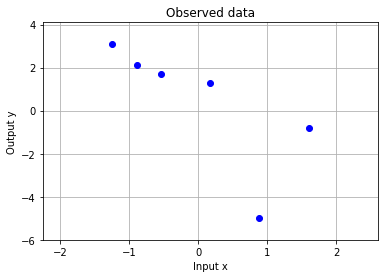

In [ ]:
#@title First dataset
#@markdown Let's build a simple dataset, with 6 $(x,y)$ pairs.  

x_data_list_outlier = jnp.array([1, 1.5, 2, 3, 4, 5])
x_data_list_outlier = (x_data_list_outlier - x_data_list_outlier.mean()) / x_data_list_outlier.std() # 
y_data_list_outlier = jnp.array([3.1, 2.1, 1.7, 1.3, -5, -0.8])

plot_basic_data(x_data_list_outlier, y_data_list_outlier)


### Finding plausible solutions with our intuition

When faced with some data, there are often multiple plausible explanations for it, that is multiple plausible functions that fit the data well. Lets try to come up with some plausible functions

**Code Task:** 
1. Move the two sliders below to set $\color{blue}{b}$ and $\color{blue}{w}$, and press "Run cell" on the code cell below. 
2. Is your $f(x)$ a good fit for the blue data points?
3. Repeat 1-2 until you have between 5 and 10 red lines you are happy with.

In [ ]:
parameters_list = [] # Used to track which parameters were tried. 

Plotting line -2.08 * x + 1.63


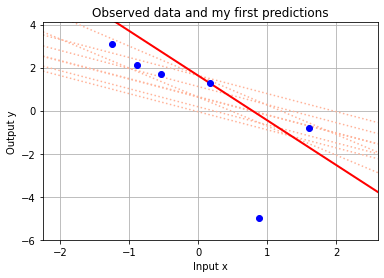

In [ ]:
b = 1.63 #@param {type:"slider", min:-1, max:8, step:0.01}
w = -2.08 #@param {type:"slider", min:-3, max:3, step:0.01}
print("Plotting line", w, "* x +", b)
parameters = [b, w]
parameters_list.append(parameters)
plot_basic_data(x_data_list_outlier, y_data_list_outlier, parameters_list,
                title="Observed data and my first predictions")

In [ ]:
manual_parameters_list = jnp.array(parameters_list)

### Now with Machine learning:

For convinience we are going to work with matrix notation.


Our targets can be written as a vector $\underline{y} = [y_0, y_1, ...]^T$ and the same for our inputs $\underline{x} = [x_0, x_1, ...]^T$. These vectors are of length matching our number of observations $N=6$.


The bias function $\color{blue}{b + w} x $ can be written as a product of an additional weight $\color{blue}{b}$ with an input that takes constant value of $1$. 

We refer to the mapping $x \to [1, x]$ as a mapping into the *affine basis*.

Our observations become a matrix $X = [[1, x_0], [1, x_1], [1, x_2], ...] \in \mathcal{R}^{N \times 2}$.


Our parameters can also become a vector $\color{blue}{\underline{w} = [b, w]^T}$ of dimension $D=2$

Our full dataset is now modelled as $\underline{y} =  X \cdot \color{blue}{\underline{w}}  + \color{red}{\underline{\epsilon}}$



In [ ]:
#@title Coding task: implement the mapping onto the affine basis

def affine_basis(x):
  """
  Maps a vector of inputs [x_0, x_1, ...] 
  onto the affine basis [[x_0, 1], [x_1, 1], [x_2, 1], ...]
  
  Args:
    x: jnp array of shape (N,) or (N,1)
  Returns:
    X: jnp array of shape (N,2)
  """
  if x.ndim == 1:
    x = x.copy()[:, None]
  
  # Your code goes 
  return X




In [ ]:
# @title Run me to test your code


X = affine_basis(x_data_list_outlier)

X_correct = jnp.stack([jnp.ones(len(x_data_list_outlier)), x_data_list_outlier], axis=1)

assert jnp.allclose(X_correct, X), "X is not calculated correctly"

print('It seems correct. Look at the answer below to compare methods.')

It seems correct. Look at the answer below to compare methods.


In [ ]:
# @title Answer  (Try not to peek until you've given it a good try!') 

def affine_basis(x):
  """
  Maps a vector of inputs [x_0, x_1, ...] 
  onto the affine basis [[1, x_0], [1, x_1], [1, x_2], ...]
  
  Args:
    x: jnp array of shape (N,) or (N,1)
  Returns:
    X: jnp array of shape (N,2)
  """
  if x.ndim == 1:
    x = x.copy()[:, None]
  
  pad_ones = jnp.ones((len(x), 1)) # the bias can be interpreted as a weight that multiplies an input with a constant value of 1 
  X = jnp.concatenate([pad_ones, x], axis=1)
  return X




In [ ]:
#@title Now we implement the linear function
#@markdown it will take a single point as input and then we will vmap it to deal with batches of inputs

#@markdown note that we will
def linear(x, w):
  return  x @ w

vmap_linear = jit(vmap(linear, in_axes=(0, None)))


**Group task** - Discuss with a neighbour:

* What does the @ operator do? 

* What would have been an alternative way to implement the linear function without using @?

* What if we want to evaluate the function for multiple weight settings $\color{blue}{\underline{w}}$, would we need to change our code?

If you are unsure about any of these get a mentor involved in your discussion!

#### Lets find the line that minimises the loss

In [ ]:
#@title Code task:
#@markdown Implement the squared error loss: 
#@markdown $\frac{1}{2}||\underline{y} - X\cdot \color{blue}{w}||_{2}^2$

def linear_regression_loss(X, y, vmap_model, w):
    """
    Computes MSE loss
    
    Args:
      X: jnp array of shape (N,2)
      y: jnp array of shape (N,)
      w: jnp array of shape (w,)
      vmap_model: function that maps (X, w) onto y
    Returns:
      squared_error: scalar
    """
    predictions = vmap_model(X, w)
    squared_error = # Your code goes here
    return squared_error


SyntaxError: ignored

In [ ]:
# @title Run me to test your code


mse = linear_regression_loss(affine_basis(x_data_list_outlier),
                      y_data_list_outlier, vmap_linear, jnp.array([2,2])) 

mse_correct = 0.5 * ((vmap_linear(affine_basis(x_data_list_outlier), jnp.array([2,2])) - y_data_list_outlier) ** 2).sum()

assert jnp.allclose(mse_correct, mse), "X is not calculated correctly"

print('It seems correct. Look at the answer below to compare methods.')

It seems correct. Look at the answer below to compare methods.


In [ ]:
# @title Answer  (Try not to peek until you've given it a good try!') 

def linear_regression_loss(X, y, vmap_model, w):
    """
    Computes MSE loss
    
    Args:
      X: jnp array of shape (N,2)
      y: jnp array of shape (N,)
      w: jnp array of shape (w,)
      vmap_model: function that maps (X, w) onto y
    Returns:
      squared_error: scalar
    """
    predictions = vmap_model(X, w)
    squared_error = 0.5 * ((y - predictions) ** 2).sum()
    return squared_error




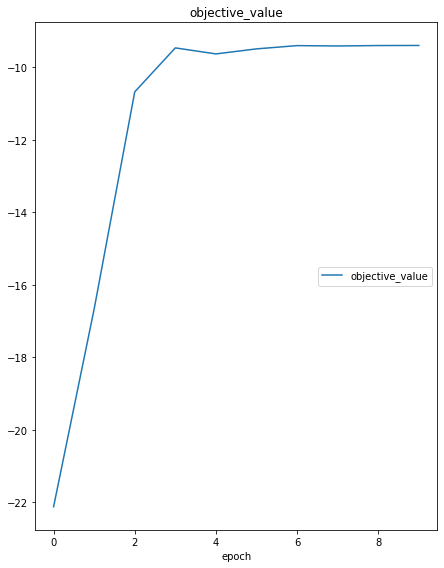

objective_value
	objective_value  	 (min:  -22.120, max:   -9.401, cur:   -9.401)
Your optimised parameter values are [ 0.40204564 -2.023999  ]


In [ ]:
#@title Lets optimise those parameters with the squared error loss


def gen_objective(X, y, vmap_model):
  def objective(params, key):
    return -linear_regression_loss(X, y, vmap_model, params)
  return objective 

objective = gen_objective(affine_basis(x_data_list_outlier),
                      y_data_list_outlier, vmap_linear)

optimised_params = optimise(objective, params=jnp.array([0.,0.]), \
                            plotting_func=None, LR=1e-2, MAX_STEPS=1000, LOG_EVERY=100)

print('Your optimised parameter values are', optimised_params)


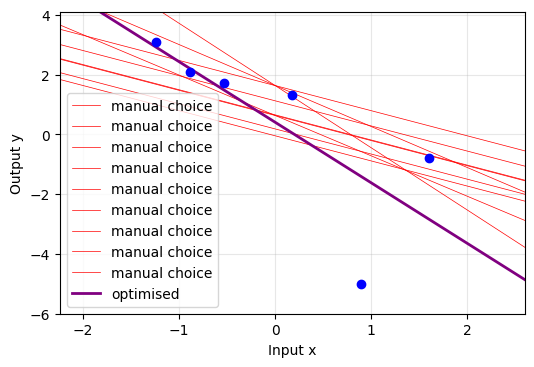

In [ ]:
#@title Lets look at how the manually chosen regression functions compare with the optimised one


plt.figure(dpi=100)

xlim = [jnp.min(x_data_list_outlier)-1, jnp.max(x_data_list_outlier)+1]
ylim = [jnp.min(y_data_list_outlier)-1, jnp.max(y_data_list_outlier)+1]

x_test = jnp.linspace(xlim[0], xlim[1], 201)
X_test = affine_basis(x_test)

ax = plt.gca()

ax.plot(x_test, vmap_linear(X_test, manual_parameters_list.T), c='red', lw=0.5, label='manual choice')
ax.plot(x_test, vmap_linear(X_test, optimised_params), c='purple', lw=2, label='optimised')

ax.plot(x_data_list_outlier, y_data_list_outlier, "ob")
ax.set(xlabel="Input x", ylabel="Output y",
      xlim=xlim, ylim=ylim)
ax.grid(alpha=0.3)
ax.legend()

**Group task** - Discuss with a neighbour and / or mentor:

* Do your manual choices look similar to those of your neighbour? 

* Are you more confident about the functions you chose or the one that the optimiser chose?

* What went wrong with the optimiser, if anything?



In [ ]:
#@title You already know the solution: adding regularisation

#@markdown Our *regularised* loss is $\frac{1}{2}||\underline{y} - X\cdot \color{blue}{\underline{w}}||_{2}^2 + \frac{\alpha}{2}||\color{blue}{\underline{w}}||_{2}^{2}$

#@markdown where $\alpha$ is the regularisation strength. 

def regularised_linear_regression_loss(X, y, vmap_model, w, alpha):
    predictions = vmap_model(X, w)
    data_fit_loss = 0.5 * ((y - predictions) ** 2).sum()
    parameter_norm = 0.5 * alpha * (w ** 2).sum()
    return (data_fit_loss + parameter_norm)


**Math Task:**
 Finding the regularised least squares solution in closed form.

Hint: take derivate with respect to $\color{blue}{\underline{w}}$ and set it to 0 to find the stationary point, i.e. the minimum. 

$\frac{\partial}{\partial \color{blue}{\underline{w}}} \frac{1}{2}||\underline{y} - X\cdot \color{blue}{\underline{w}}||_{2}^2 + \frac{\alpha}{2}||\color{blue}{\underline{w}}||_{2}^{2} =0
$


In [ ]:
#@markdown What is the solution? (Options given already in code)

selection =  'solve(X.T @ X + alpha * jnp.eye(X.shape[1]), X.T @ y)' #@param ['X.T @ X + alpha * jnp.eye(w.shape[0])', "solve(X.T @ X + alpha * jnp.eye(X.shape[1]), X.T @ y)", "jnp.linalg.inv(X.T @ X) @ (\alpha + X.T @ y)"]
print(f"You selected: {selection}")

You selected: X.T @ X + alpha * jnp.eye(w.shape[0])


In [ ]:
#@title Coding task: choose one of the 3 options from above

def regularised_least_squares_solution(X, y, alpha):
  return # Paste the solution here
  

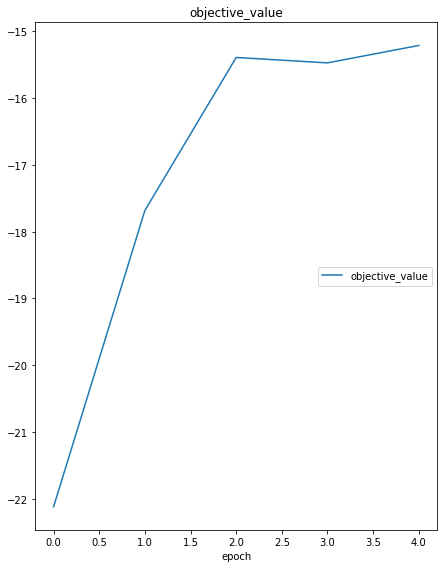

objective_value
	objective_value  	 (min:  -22.120, max:  -15.210, cur:  -15.210)
Your regularised optimised parameter values are [ 0.22701867 -1.0797694 ]
Your regularised exact parameter values are None


In [ ]:
#@title Lets solve the problem with the regulariser
#@markdown Lets start with $\alpha=5$.

#@markdown Llay around with different $\alpha$ values to find the one that gives solutions that "feel" the best

alpha=5


exact_regularised_params = regularised_least_squares_solution(affine_basis(x_data_list_outlier), y_data_list_outlier, alpha)
# Hint: the correct solution to the above question was (b)

def gen_objective(X, y, vmap_model, alpha):
  def objective(params, key):
    return -regularised_linear_regression_loss(X, y, vmap_model, params, alpha)
  return objective 

objective = gen_objective(affine_basis(x_data_list_outlier),
                      y_data_list_outlier, vmap_linear, alpha)

optimised_regularised_params = optimise(objective, params=jnp.array([0.,0.]), \
                            plotting_func=None, LR=1e-2, MAX_STEPS=500, LOG_EVERY=100)

print('Your regularised optimised parameter values are', optimised_regularised_params)
print('Your regularised exact parameter values are', exact_regularised_params)


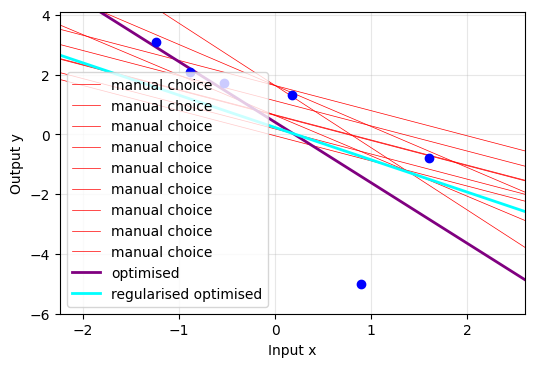

In [ ]:
#@title Lets look at how the manually chosen regression functions compare with the regularised and unregularised ones


plt.figure(dpi=100)

xlim = [jnp.min(x_data_list_outlier)-1, jnp.max(x_data_list_outlier)+1]
ylim = [jnp.min(y_data_list_outlier)-1, jnp.max(y_data_list_outlier)+1]

x_test = jnp.linspace(xlim[0], xlim[1], 201)
X_test = affine_basis(x_test)

ax = plt.gca()

ax.plot(x_test, vmap_linear(X_test, manual_parameters_list.T), c='red', lw=0.5, label='manual choice')
ax.plot(x_test, vmap_linear(X_test, optimised_params), c='purple', lw=2, label='optimised')
ax.plot(x_test, vmap_linear(X_test, optimised_regularised_params), c='cyan', lw=2, label='regularised optimised')

ax.plot(x_data_list_outlier, y_data_list_outlier, "ob")
ax.set(xlabel="Input x", ylabel="Output y",
      xlim=xlim, ylim=ylim)
ax.grid(alpha=0.3)
ax.legend()

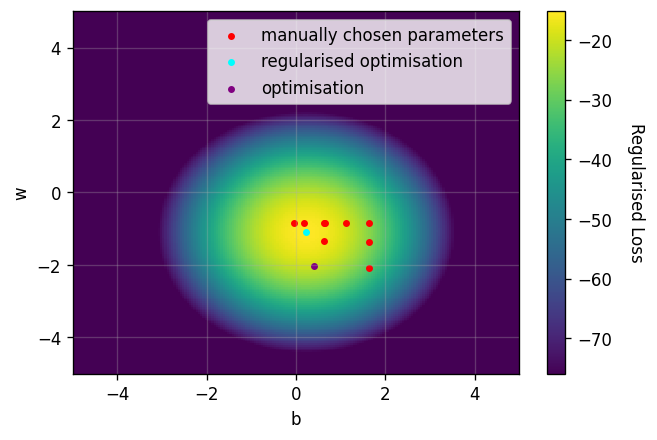

In [ ]:
#@title The loss landscape accomodates multiple solutions!
#@markdown Lets plot the loss for a large grid of $b$ and $w$ values to see which ones would work well


def generate_loss_fun():
  def loss_fun(w):
    return regularised_linear_regression_loss(X=affine_basis(x_data_list_outlier),
                    y=y_data_list_outlier, w=w, vmap_model=vmap_linear, alpha=alpha)
  return loss_fun
loss_fun = generate_loss_fun()

x0_grid, x1_grid, loss_grid = generate_loss_grid(loss_fun=loss_fun, grid_size=200, lim0=[-5,5], lim1=[-5,5])


plt.figure(dpi=120)
plt.pcolormesh(x0_grid, x1_grid, -loss_grid, vmin=-loss_grid.min() * 5, vmax=-loss_grid.min(), cmap='viridis') # 
plt.ylabel('w')
plt.xlabel('b')
plt.grid(alpha=0.3)
cbar = plt.colorbar()
cbar.set_label('Regularised Loss', rotation=270, labelpad=20)

plt.scatter(manual_parameters_list[:,0], manual_parameters_list[:, 1], 10, color='red', label='manually chosen parameters')
plt.scatter(optimised_regularised_params[0], optimised_regularised_params[1], 10, color='cyan', label='regularised optimisation')
plt.scatter(optimised_params[0], optimised_params[1], 10, color='purple', label='optimisation')

plt.legend()




It turns out that all of the parameter combinations in the yellow region of the loss surface could have worked quite well!

### **Takeaways**: trust your instincts!

1. Our intuition about what is a "good" solution alligns more with the solutions chosen by the regularised objective. Does this mean our brain is intrinsically performing regularisation?!?!

2. Using our intuition, we were able to come up with multiple plausible solutions for the data. Doesnt it feel kind of wrong that the optimiser only gives us 1 solution?

# Section 1 - From regression to Bayesian linear regression

Now we are going to formalise the intuition from the previous section.


In the Bayesian framework, we pick a model which we beleive could have generated the data. We already have such a model:

<center> 
$\underline{y} =  X \cdot \color{blue}{\underline{w}}  + \color{red}{\underline{\epsilon}}$
</center>,

Although the exact value of $\color{blue}{\underline{w}}$ is unknown a priori (before observing the data), we do have some prior knowledge we can incorporate into our problem. For instance, we might not want to chsose a very large slope for our regression line, since this often happens when we overfit to some outlier. That is why we used the regulariser in the previous section.

Mathematically, we express the fact that we do not know what value $\color{blue}{\underline{w}}$ should have but that we think it should be smallish through the choice of a prior probability distribution $p(\color{blue}{\underline{w}})$ that places more probability mass near 0.

The most common choice to satisfy this desiderata, and easiest to work with, is the 0 mean Gaussian:

<center> 
$\color{blue}{\underline{w}} \sim \mathcal{N}(0, \alpha^{-1} I)$
</center>

<center> 
<img src="https://i.imgur.com/JWykW0I.png" width="40%" />
</center>


Even if we knew the exact value of $\color{blue}{\underline{w}}$, we would still be unable to retrieve $\underline{y}$ given $X$ and $\color{blue}{\underline{w}}$. This is because in general our observations are corrupted by the residuals $\color{red}{\underline{\epsilon}}$. 

$\color{red}{\underline{\epsilon}}$ represents some noise that can not be predicted from $X$ alone, e.g. thermal noise in the measurement of a voltage value. Since we do not know what value \color{red}{\underline{\epsilon}} takes a priori, we also model \color{red}{\underline{\epsilon}} with a probability distribution $p(\color{red}{\underline{\epsilon}})$.


<center> Lets keep it simple and choose the Gaussian
$  \,\,\,\color{red}{\underline{\epsilon}} \sim \mathcal{N}(0, I)$
</center>


We are ready to write our full probabilistic model. Given inputs and weights, our targets follow the distribution

$p(\underline{y} | X, \color{blue}{\underline{w}}) = \mathcal{N}(\underline{y}; X\cdot \color{blue}{\underline{w}}, I) = \frac{1}{ (2 \pi)^{N/2} } \exp(\frac{- (y - X \cdot \color{blue}{\underline{w}})^T (y - X \cdot \color{blue}{\underline{w}})}{2})$ 

and our weights follow the distribution

$p(\color{blue}{\underline{w}}) = \mathcal{N}(\color{blue}{\underline{w}}; 0, \alpha^{-1} I) = \frac{1}{ (2 \pi \alpha)^{D/2} } \exp(\frac{-\alpha \color{blue}{\underline{w}}^T \color{blue}{\underline{w}}}{2})$

where $N$ is the number of observations and $D$ the size of $\color{blue}{\underline{w}}$.

## Bayesian learning of our parameters $\color{blue}{\underline{w}}$


We want to identify the parameter settings that 
1. are likely under our prior: $p(\color{blue}{\underline{w}})$
**and**
2. Fit the data well: $p(\underline{y} | X, \color{blue}{\underline{w}})$

We can score parameter settings by how well they satisfy both constraints simultaneously by considering the product 

<center> 
$p(\underline{y} | X, \color{blue}{\underline{w}}) p(\color{blue}{\underline{w}})$.
</center> 

Unfortunately, when you multiply two probability distributions, you are not guaranteed to get something that integrates to 1 (a key requirement for something to be a probability distribution). This is why we need to renormalise by $p(\underline{y} | X) = \int p(\underline{y} | X, \color{blue}{\underline{w}}) p(\color{blue}{\underline{w}}) d \color{blue}{\underline{w}}$.

Putting it all together we have $\frac{p(\underline{y} | X, \color{blue}{\underline{w}}) p(\color{blue}{\underline{w}})}{p(\underline{y} | X)}$. This expression is our posterior distribution over parameters $p(\color{blue}{\underline{w}} | \underline{y}, X)$ and represents how likely each parameter setting is given our prior and data.

The procedure of computing the posterior is also known as **inference**.

<font color='green'>`Fun fact`</font>: in large scale machine learning, "inference" is used to mean "making predictions". This is a miss-use of the word that stuck!

**Math Task**: compute the posterior distribution $p(\color{blue}{\underline{w}} | \underline{y}, X) = \frac{p(\underline{y} | X, \color{blue}{\underline{w}}) p(\color{blue}{\underline{w}})}{p(\underline{y} | X)}$ for our linear regression model

$p(\underline{y} | X, \color{blue}{\underline{w}}) = \mathcal{N}(\underline{y}; X\cdot \color{blue}{\underline{w}}, I) = \frac{1}{ (2 \pi)^{N/2} } \exp(\frac{- (y - X \cdot \color{blue}{\underline{w}})^T (y - X \cdot \color{blue}{\underline{w}})}{2})$ 

$p(\color{blue}{\underline{w}}) = \mathcal{N}(\color{blue}{\underline{w}}; 0, \alpha^{-1} I) = \frac{1}{ (2 \pi \alpha)^{D/2} } \exp(\frac{-\alpha \color{blue}{\underline{w}}^T \color{blue}{\underline{w}}}{2})$

\
* Hint 1: The product of Gaussian distributions gives us a Gaussian scaled by a constant $c$. 
<center>
$\mathcal{N}(\color{blue}{\underline{w}}; 0, \alpha^{-1} I) \mathcal{N}(\underline{y}; X\cdot \color{blue}{\underline{w}}, I) = c \cdot \mathcal{N}(\color{blue}{\underline{w}}; \mu, \Sigma)$
</center>

c is $p(\underline{y} | X)^{-1}$ and is independent of $\color{blue}{\underline{w}}$ so we dont care about it. Your job is to find $\mu$ and $\Sigma$.

\
* Hint 2: Nottice that $\color{blue}{\underline{w}}$ only appears in the exponential terms of our distributions. This means that we can ignore the non-exponential terms because these will only affect $c$. Thus you need to only consider the expression

<center>
$\frac{- (y - X \cdot \color{blue}{\underline{w}})^T (y - X \cdot \color{blue}{\underline{w}})}{2} + \frac{-\alpha \color{blue}{\underline{w}}^T \color{blue}{\underline{w}}}{2} = \frac{- (\color{blue}{\underline{w}} - \mu)^T \Sigma^{-1} (\color{blue}{\underline{w}} - \mu)}{2}$
</center>

Try to solve for $\Sigma$ first. If you get stuck, ask a mentor!

<font color='red'>`TODO: reveal hints progressively`</font>


In [ ]:

# @title Answer to math task (Try not to run until you've given it a good try!') 
from IPython.display import display, Markdown, Latex
display(Latex(f"$\\Sigma = (X.T X + \\alpha I)^{-1}$"))
display(Latex("$\mu = \Sigma X^T y"))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [ ]:
#@title **coding task**: implement a method that computes the posterior for linear regression

def BLR_posterior(X, y, alpha):
    """
    Computes linear regression posterior parameters
    
    Args:
      X: jnp array of shape (N,D)
      y: jnp array of shape (N,)
      alpha: scalar - regulasisation strength
    Returns:
      mu: jnp array of shape (D,)
      covariance: jnp array of shape (D,D)
    """
    D = X.shape[1] # D=2 parameters, one weight and 1 bias
    # Your code goes here
    return mu, covariance






In [ ]:
# @title Run me to test your code

alpha = 5
mu, covariance = BLR_posterior(affine_basis(x_data_list_outlier), y_data_list_outlier, alpha)

mu_correct = jnp.array([ 0.21818179, -1.101769 ])
covariance_correct = jnp.array([[9.090909e-02, 9.852008e-10],
 [9.852008e-10, 9.090909e-02]])

assert jnp.allclose(mu_correct, mu), "mu is not calculated correctly"
assert jnp.allclose(covariance_correct, covariance), "Covariance is not calculated correctly"

print('It seems correct. Look at the answer below to compare methods.')

It seems correct. Look at the answer below to compare methods.


In [ ]:
# @title Answer  (Try not to peek until you've given it a good try!') 

def BLR_posterior(X, y, alpha):
    """
    Computes linear regression posterior parameters
    
    Args:
      X: jnp array of shape (N,D)
      y: jnp array of shape (N,)
      alpha: scalar - regulasisation strength
    Returns:
      mu: jnp array of shape (D,)
      covariance: jnp array of shape (D,D)
    """
    D = X.shape[1] # D=2 parameters, one weight and 1 bias
    precision = X.T @ X + alpha * jnp.eye(D)
    covariance = jnp.linalg.inv(precision)
    mu = solve(precision, (X.T @ y))
    return mu, covariance



### posterior is normalised loss surface

Consider the log of the unnormalised posterior

<center>
$\log \left( p(\underline{y} | X, \color{blue}{\underline{w}}) p(\color{blue}{\underline{w}}) \right) = \log \left( \mathcal{N}(\underline{y}; X\cdot \color{blue}{\underline{w}}, I) \mathcal{N}(\color{blue}{\underline{w}}; 0, \alpha^{-1} I)\right)$

\
$= \frac{- (y - X \cdot \color{blue}{\underline{w}})^T (y - X \cdot \color{blue}{\underline{w}})}{2} + \frac{-\alpha \color{blue}{\underline{w}}^T \color{blue}{\underline{w}}}{2} + C$

\
$= \frac{-1}{2}||\underline{y} - X\cdot \color{blue}{\underline{w}}||_{2}^2 + \frac{-\alpha}{2}||\color{blue}{\underline{w}}||_{2}^{2} + C$

</center>

where $C$ is a constant independent of $\color{blue}{\underline{w}}$.

Since the log is a monotonic function, we have just derived that the weight settings that minimise our loss are the same ones that minimise our posterior! 

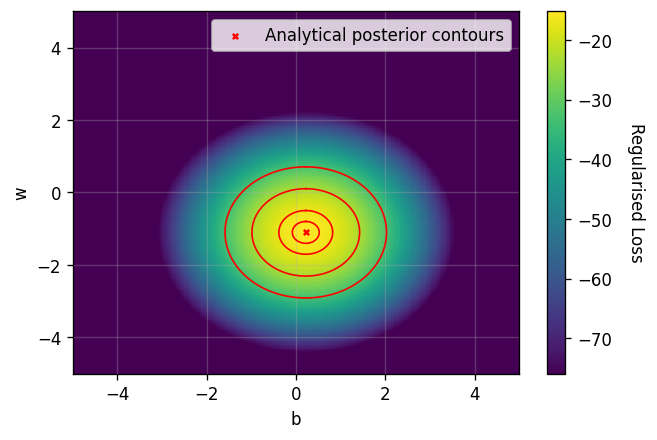

In [ ]:
#@title We can plot our log posterior distribution by plotting our loss landscape, since both are equal up to a constant. 

alpha = 5
mu, covariance = BLR_posterior(affine_basis(x_data_list_outlier), y_data_list_outlier, alpha)

def generate_loss_fun():
  def loss_fun(w):
    return regularised_linear_regression_loss(X=affine_basis(x_data_list_outlier),
                    y=y_data_list_outlier, w=w, vmap_model=vmap_linear, alpha=alpha)
  return loss_fun
loss_fun = generate_loss_fun()

x0_grid, x1_grid, loss_grid = generate_loss_grid(loss_fun=loss_fun, grid_size=200, lim0=[-5,5], lim1=[-5,5])


plt.figure(dpi=120)
plt.pcolormesh(x0_grid, x1_grid, -loss_grid, vmin=-loss_grid.min() * 5, vmax=-loss_grid.min(), cmap='viridis') # 
plt.ylabel('w')
plt.xlabel('b')
plt.grid(alpha=0.3)
cbar = plt.colorbar()
cbar.set_label('Regularised Loss', rotation=270, labelpad=20)

ax = plt.gca()
plot_log_gaussian_ellipse(ax=ax, mean=mu, cov=covariance, color='r',
                          alpha=1, lw=1, label='Analytical posterior contours', MAP_size=10, std_levels=[1, 2, 4, 6])

plt.legend()




Thus, Bayesian inference is just trying to find all of the parameter settings that have low loss, i.e. that fit both our regulariser and data well



### Making predictions the Bayesian way!


In [ ]:
#@title Exact predictive posterior for Bayesian Linear regression
#@markdown A nice property of Gaussians is that linear transformations of Gaussian random variables are also Gaussian:
#@markdown if $\color{blue}{\underline{w}} \sim \mathcal{N}(\mu, \Sigma)$ then $X\cdot \color{blue}{\underline{w}} \sim \mathcal{N}(X \cdot \mu, X \Sigma X^T)$

#@markdown lets code this up! Instead of returning the full covariance we will return the square root of the diagonal. This is the predictive standard deviation, which is nice for plotting.


def BLR_predictions(X, mu, covariance):
    """
    Computes linear regression posterior predictive distribution.
    Instead of returning the full covariance we will return the square root of the diagonal. This is the predictive standard deviation, which is nice for plotting.

    Args:
      X: jnp array of shape (N,D)
      mu: jnp array of shape (D,)
      covariance: jnp array of shape (D,D)
    Returns:
      predictive_mean: jnp array of shape (N,)
      predictive_std: jnp array of shape (N,)
    """
    predictive_mean = X @ mu
    predictive_std = jnp.diag(X @ covariance @ X.T) ** 0.5
    return predictive_mean, predictive_std
    


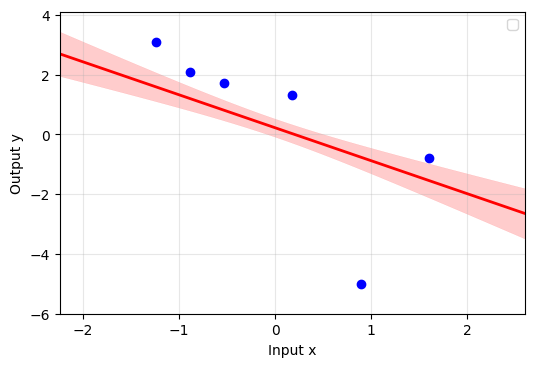

In [ ]:

plt.figure(dpi=100)

xlim = [jnp.min(x_data_list_outlier)-1, jnp.max(x_data_list_outlier)+1]
ylim = [jnp.min(y_data_list_outlier)-1, jnp.max(y_data_list_outlier)+1]

x_test = jnp.linspace(xlim[0], xlim[1], 201)
X_test = affine_basis(x_test)

predictive_mean, predictive_std = BLR_predictions(X_test, mu, covariance)

ax = plt.gca()
errorfill(x_test, predictive_mean, predictive_std, color='red', alpha_fill=0.2, line_alpha=1, ax=ax,
              lw=2, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label=None, markevery=None)


ax.plot(x_data_list_outlier, y_data_list_outlier, "ob")
ax.set(xlabel="Input x", ylabel="Output y",
      xlim=xlim, ylim=ylim)
ax.grid(alpha=0.3)
ax.legend()



In [ ]:
#@title Even when the exact solution is not available, we can always rely on Monte Carlo
#@markdown We can draw plausible predictive functions by sampling weights $\color{blue}{\underline{w}} \sim \mathcal{N}(\mu, \Sigma)$ and then applying our function $f(X, w)  = X \cdot \color{blue}{\underline{w}}$
#@markdown we can then estimate quantities of interest like mean and standard deviation from the samples


key = random.PRNGKey(0)
Nsamples = 10

parameter_samples = jax.random.multivariate_normal(key, mu, covariance, shape=(Nsamples,))
sample_preds = vmap_linear(X_test, parameter_samples.T)
MC_mean = sample_preds.mean(axis=1)
MC_std = sample_preds.std(axis=1)



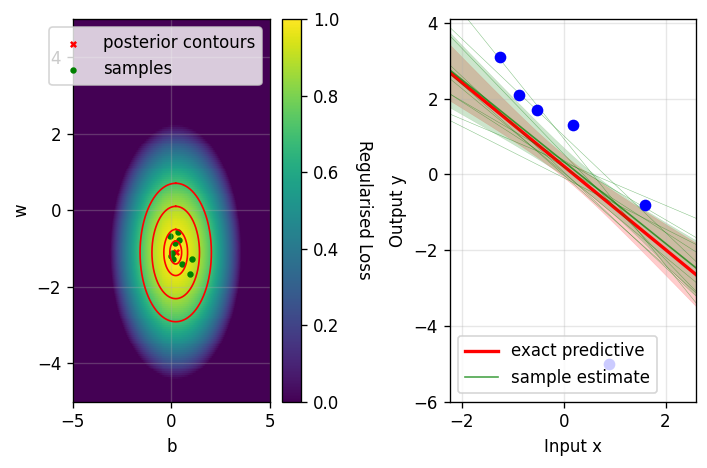

In [ ]:


fig, ax = plt.subplots(1,2, dpi=120, figsize=(6,4))


ax[0].pcolormesh(x0_grid, x1_grid, -loss_grid, vmin=-loss_grid.min() * 5, vmax=-loss_grid.min(), cmap='viridis') # 
ax[0].set_ylabel('w')
ax[0].set_xlabel('b')
ax[0].grid(alpha=0.3)
#cbar = ax[0].colorbar()
cbar.set_label('Regularised Loss', rotation=270, labelpad=20)

plot_log_gaussian_ellipse(ax=ax[0], mean=mu, cov=covariance, color='r',
                          alpha=1, lw=1, label='posterior contours', MAP_size=10, std_levels=[1, 2, 4, 6])

p = ax[0].scatter(parameter_samples[:,0], parameter_samples[:,1], 8, color='green', label='samples')
cbar = fig.colorbar(p, ax=ax[0])
cbar.set_label('Regularised Loss', rotation=270, labelpad=20)
ax[0].legend()



xlim = [jnp.min(x_data_list_outlier)-1, jnp.max(x_data_list_outlier)+1]
ylim = [jnp.min(y_data_list_outlier)-1, jnp.max(y_data_list_outlier)+1]

x_test = jnp.linspace(xlim[0], xlim[1], 201)
X_test = affine_basis(x_test)

errorfill(x_test, predictive_mean, predictive_std, color='red', alpha_fill=0.2, line_alpha=1, ax=ax[1],
              lw=2, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='exact predictive', markevery=None)

ax[1].plot(x_test, sample_preds, "-", color='green', lw=0.3, alpha=0.5)
errorfill(x_test, MC_mean, MC_std, color='green', alpha_fill=0.2, line_alpha=0.7, ax=ax[1],
              lw=1, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='sample estimate', markevery=None)



ax[1].plot(x_data_list_outlier, y_data_list_outlier, "ob")
ax[1].set(xlabel="Input x", ylabel="Output y",
      xlim=xlim, ylim=ylim)
ax[1].grid(alpha=0.3)
ax[1].legend()

plt.tight_layout()



**Group task** - Discuss with a neighbour:

* Is our sample based estimate of the predictive distribution good? Do we have enough samples?
* Why are the errorbars smaller near the training data?
* How would the errorbars change if we added more data (observations)? What about if we decreased the number of observations? What about if we increased the regularisation strength?
* What observation (as in [x, y] value pair) would we have to make to maximally decrease the errorbar size?

## With a more sophisticated basis linear regression can be very powerfull (Optional) - <font color='orange'>`Intermediate`</font>

Lets introduce a dataset that requires a non-linear model.


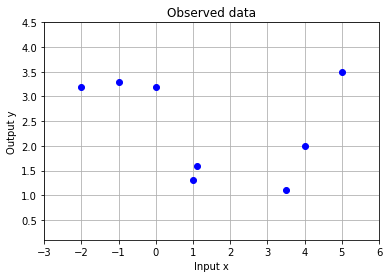

In [ ]:
x_data_list_nonlinear = jnp.array([-2, -1, 0, 1, 1.1, 3.5, 4, 5])
y_data_list_nonlinear = jnp.array([3.2, 3.3, 3.2, 1.3, 1.6, 1.1, 2., 3.5])

plot_basic_data(x_data_list_nonlinear, y_data_list_nonlinear)



So far we have used the affine basis $x \to [1, x]$. This allows us to generate lines with a learnt slope and offset. 

Now consider the basis $x \to [\cos(s_{0} x + u_{0}), \cos(s_{1} x + u_{1}), \,...]$ where $\,\,s_{i} \sim \mathcal{N}(0, \sigma^{2})$ and $\,\,u_{i} \sim U(-\pi, \pi)$.

This is known as "random fourier" basis and given a large enough amount basis functions it will allow us to model any function. See the paper [Random Features for Large-Scale Kernel Machines](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf) for more details on this basis.


In [ ]:

def generate_cosine_basis(key, N_inputs, N_elements, s_std=1):
  
  key, _ = random.split(key)
  S = random.normal(key, shape=(N_inputs, N_elements)) * s_std
  key, _ = random.split(key)
  u = (random.uniform(key, shape=(N_elements,)) - 0.5) * 2 * jnp.pi

  def basis_expand(x):
    if x.ndim == 1:
      x = x.copy()[:,None]
    return jnp.cos(x @ S + u)

  return basis_expand


N_inputs = 1
N_elements = 100

fourier_basis = generate_cosine_basis(key, N_inputs, N_elements, s_std=0.75)



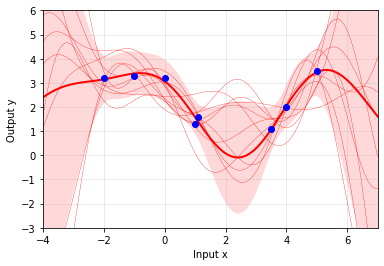

In [ ]:
#@title Run regression the same as with the affine basis
xlim = [-4, 7]

alpha = 0.5


X = fourier_basis(x_data_list_nonlinear)
mu, covariance = BLR_posterior(X, y_data_list_nonlinear, alpha)


x_pred = jnp.linspace(xlim[0], xlim[1], 101)
X_pred = fourier_basis(x_pred)


parameter_samples = jax.random.multivariate_normal(key, mu,  covariance, shape=(Nsamples,))
sample_preds = vmap_linear(X_pred, parameter_samples.T)

predictive_mean, predictive_std = BLR_predictions(X_pred, mu, covariance)

#################

fig, ax = plt.subplots()
ylim = [-3, 6]
ax.plot(x_pred, sample_preds, "-", color='red', lw=0.3)

errorfill(x_pred, predictive_mean, predictive_std, color='red', alpha_fill=0.15, line_alpha=1, ax=ax,
              lw=2, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label=None, markevery=None)

ax.plot(x_data_list_nonlinear, y_data_list_nonlinear, "ob")
ax.set(xlabel="Input x", ylabel="Output y",
      xlim=xlim, ylim=ylim)
ax.grid(alpha=0.3)


**Group task** - Discuss with a neighbour:

* Why do the errorbars grow so large in the [1, 3] range and outside the x = [-1, 5] range?
* What effect does $\alpha$ have? What about the random frequency standard deviation $\sigma$? 

## The model evidence for hyperparameter selection (Optional) - <font color='red'>`Advanced`</font>


Recall the equality...

TODO

In [ ]:
#@title linear regression model evidence
#@markdown the free parameters are the regularisation strength $\alpha$ and the choice of basis

def linear_evidence(x_data_list, y_data_list, basis, alpha):
    X = basis(x_data_list)
    mu, covariance = BLR_posterior(X, y_data_list, alpha)
    loss = regularised_linear_regression_loss(X=X,
                    y=y_data_list, w=mu, vmap_model=vmap_linear, alpha=alpha)
    a, log_det = jnp.linalg.slogdet(covariance)
    return -loss + 0.5 * (len(mu) * jnp.log(alpha) + log_det) - 0.5 * len(x_data_list) * jnp.log(2 * jnp.pi) 


alpha=10
fourier_evidence = linear_evidence(x_data_list_nonlinear, y_data_list_nonlinear, fourier_basis, alpha)
affine_evidence = linear_evidence(x_data_list_nonlinear, y_data_list_nonlinear, affine_basis, alpha)
print('fourier_evidence', fourier_evidence)
print('affine_evidence', affine_evidence)


fourier_evidence -14.676246
affine_evidence -24.017353


**Some questions**
* Why is the fourier model's evidence larger than the affine model's evidence?
* Is the same true for the other dataset? (x_data_list_nonlinear, y_data_list_nonlinear)

In [ ]:
#@title **code task**: Optimise the fourier basis standard deviation $\sigma$ and the regularisation strength $\alpha$ with the linear evidence objective



**Some more questions**
* Is there any overfitting happening? 
* When is it safe to use the model evidence as a training objective for our hyperparameters?

# Section 2 - Logistic Regression -- the need for approximate inference


We are now ready to exit the world of exact solutions which you can compute with pen and paper.

We will start by considering logistic regression. We are going to deal with a classification task where our targets are either 0 or 1. Data that takes these values can be described by a [Bernouilli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution)

<center>
$y_{n} \sim \text{Bern}(\rho)$
</center>

where $\rho \in [0,1]$ is the probability of our observations taking a value of 1.  Our model will predict this probability for each of the inputs: $\rho = f(x, \color{blue}{\underline{w}})$.

We will use the same affine linear model as before, but we need to restrict the output to the $[0,1]$ range so we use the sigmoid function $\phi(f) = \frac{1}{1 + \exp(-f)}$.

\
Putting it all together we have 

<center>
$p(\underline{y} | X, \color{blue}{\underline{w}}) = \prod_{n=1}^N Bern(y_{n}; \phi(x_{n}\color{blue}{\underline{w}}))$

and as before we keep the Gaussian prior over our parameters
\
$p(\color{blue}{\underline{w}}) = \mathcal{N}(\color{blue}{\underline{w}}; 0, \alpha^{-1} I)$
</center>



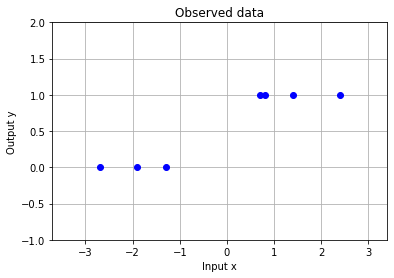

In [ ]:
#@title Dataset for logistic regression.
#@markdown the task will be to classify points with the labels 0 or 1

x_data_list_classification = jnp.array([-2.7, -1.9, -1.3, 0.7, 0.8, 1.4, 2.4])
y_data_list_classification = jnp.array([0, 0, 0, 1, 1, 1, 1])


plot_basic_data(x_data_list_classification, y_data_list_classification)



In [ ]:
#@title Define the model, same as above

def logistic(w, x):
  return sigmoid(linear(w, x))

vmap_logistic = jit(vmap(logistic, in_axes=(None, 0)))



## Loss landscape is non-quadratic


Similarly to linear reression, lets write out the unnormalised posterior to get a loss function to optimise. 

<center>
$\log \left( p(\underline{y} | X, \color{blue}{\underline{w}}) p(\color{blue}{\underline{w}}) \right) = \log \left( \prod_{n=1}^N Bern(y_n ; \phi(x_n \color{blue}{\underline{w}})) \mathcal{N}(\color{blue}{\underline{w}}; 0, \alpha^{-1} I)\right)$
</center>

\
Now we note that the Bernouilli density is $Bern(y ; \rho) = \rho^y (1-\rho)^{(1-y)}$. And when we take its log we recover the cross entropy loss: $y \log \rho + (1-y) \log (1-\rho)$


\
Dropping constants, the total loss is thus going to be

<center>
$\sum_{n=1}^N y_n \log \phi(x_n \color{blue}{\underline{w}}) + (1-y_n) \log (1-\phi(x_n \color{blue}{\underline{w}})) + \frac{\alpha}{2} ||\color{blue}{\underline{w}}||_{2}^2$
</center>

i.e. the regularised cross entropy loss falls right out of our Bayesian model!

In [ ]:
#@title Implementation of regularised cross entropy loss
#@markdown nottice that we do not code the sigmoid since it is implicit in the `sigmoid_binary_cross_entropy` method

#@markdown combining sigmoid and cross entropy in this way provides increased numerical stability

def logistic_regression_loss(X, y, vmap_model, w, alpha):
    data_fit_loss = sigmoid_binary_cross_entropy(vmap_model(X, w), y).sum(axis=0) # optax loss has sigmoid integrated so we just use linear model
    parameter_norm = 0.5 * alpha * (w ** 2).sum()
    return (data_fit_loss + parameter_norm)



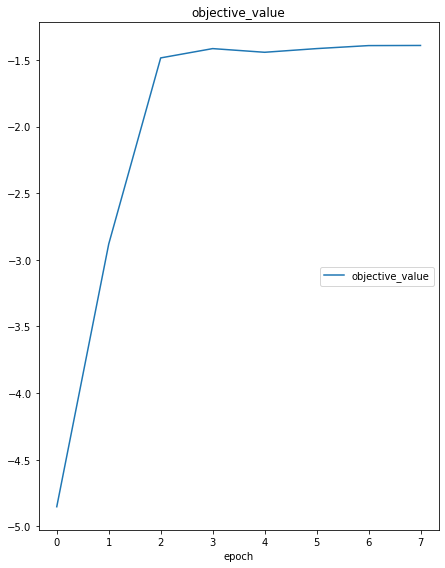

objective_value
	objective_value  	 (min:   -4.852, max:   -1.392, cur:   -1.392)


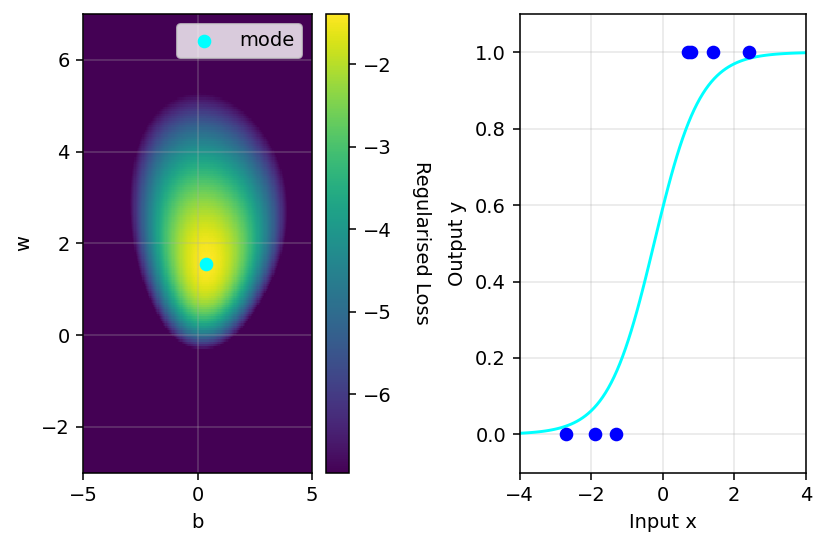

In [ ]:
#@title Plotting the loss landscape and find the solution at the mode

alpha = 0.5


def generate_loss_fun():
  def loss_fun(w):
    return logistic_regression_loss(X=affine_basis(x_data_list_classification),
                    y=y_data_list_classification, vmap_model=vmap_linear, w=w, alpha=alpha)
  return loss_fun
loss_fun = generate_loss_fun()

x0_grid, x1_grid, loss_grid = generate_loss_grid(loss_fun=loss_fun, grid_size=200, lim0=[-5,5], lim1=[-3,7])



def gen_objective(X, y, vmap_model, alpha):
  def objective(params, key):
    return -logistic_regression_loss(X, y, vmap_model, params, alpha)
  return objective 

objective = gen_objective(affine_basis(x_data_list_classification),
                      y_data_list_classification, vmap_linear, alpha)

optimised_regularised_classification_params = optimise(objective, params=jnp.array([0.,0.]), \
                            plotting_func=None, LR=1e-2, MAX_STEPS=800, LOG_EVERY=100)


fig, ax = plt.subplots(1,2, dpi=140)
mesh = ax[0].pcolormesh(x0_grid, x1_grid, -loss_grid, vmin=-loss_grid.min() * 5, vmax=-loss_grid.min(), cmap='viridis') # 
cbar = fig.colorbar(mesh, ax=ax[0])
cbar.set_label('Regularised Loss', rotation=270, labelpad=20)
ax[0].set_ylabel('w')
ax[0].set_xlabel('b')
ax[0].grid(alpha=0.3)
ax[0].scatter(optimised_regularised_classification_params[0], optimised_regularised_classification_params[1], c='cyan', label='mode')
ax[0].legend()


xlim = [-4,4]
ylim = [-0.1, 1.1]

x_pred = jnp.linspace(xlim[0], xlim[1], 101)


mode_predictions = sigmoid(vmap_linear(affine_basis(x_pred), optimised_regularised_classification_params))
ax[1].plot(x_pred, mode_predictions, c='cyan')
ax[1].grid(alpha=0.3)

ax[1].plot(x_data_list_classification, y_data_list_classification, "ob")
ax[1].set(xlabel="Input x", ylabel="Output y",
      xlim=xlim, ylim=ylim)
plt.tight_layout()
plt.show()


**Group task** - Discuss with a neighbour and / or mentor:

* Is the loss quadratic? Is the loss convex?

* What is the cause of the posterior sheer in the $w$ direction?

* When normalised, will the posterior be Gaussian?

* Nottice that the Gaussian posterior contours from the previous section are symmetric around their mode. Is this loss landscape symmmetric around its mode? What do you think will be the implications of approximating this posterior distribution with a Gaussian.


# Section 3: Black Box Variational Inference 

The logistic regression posterior is non-quadratic and thus non-Gaussian. Even worse, we do not have a closed form expression for the posterior distribution. However, after [Section 1](https://colab.research.google.com/drive/1YPGSBmkwhrw16x8HstOENt2QCeNts7aT#scrollTo=-ZUp8i37dFbU), we are very comfortable  working with Gaussians.

We are going to try to find the Gaussian which is closest to the logistic regression posterior and use that one. We are going to call it $q$. We will learn its mean and covariance parameters $\mu_q, \Sigma_q$: $q(\color{blue}{\underline{w}}) = \mathcal{N}(\color{blue}{\underline{w}}; \mu_q, \Sigma_q)$

But, what do we mean by closest? We need to choose a notion of distance between distributions. We are going to choose the [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence). That is, we want to minimise the KL divergence between our approximation $q(\color{blue}{\underline{w}})$ and the true posterior $p(\color{blue}{\underline{w}} | X, \underline{y})$ which we write as $\text{KL}(q(\color{blue}{\underline{w}}) \, ||\, p(\color{blue}{\underline{w}} | X, \underline{y}))$.



## Introducing the ELBO

But we dont know the anaylitical form of $p(\color{blue}{\underline{w}} | X, \underline{y})$, so how do we minimise $\text{KL}(q(\color{blue}{\underline{w}}) \, ||\, p(\color{blue}{\underline{w}} | X, \underline{y}))$?

We are going to use a trick called the Evidence Lwer BOund (ELBO). Specifically, we are going to derive that maximising the objective 

<center>
$\text{ELBO} = \mathbb{E}_{q(\color{blue}{\underline{w}})}[\log p(\underline{y} | X, \color{blue}{\underline{w}})]$ - $\text{KL}(q(\color{blue}{\underline{w}}) \, ||\, p(\color{blue}{\underline{w}}))$
</center>

is equivalent to minimising $\text{KL}(q(\color{blue}{\underline{w}}) \, ||\, p(\color{blue}{\underline{w}} | X, \underline{y}))$. This is great because the ELBO does not contain the posterior anymore, only the likelihood $p(\underline{y} | X, \color{blue}{\underline{w}})]$ and prior $p(\color{blue}{\underline{w}})$!

**Math Task**: Derive the ELBO


<center>
Show that minimising $\text{KL}(q(\color{blue}{\underline{w}}) \, ||\, p(\color{blue}{\underline{w}} | X, \underline{y}))$ is equivalent to maximising $\mathbb{E}_{q(\color{blue}{\underline{w}})}[\log p(\underline{y} | X, \color{blue}{\underline{w}})]$ - $\text{KL}(q(\color{blue}{\underline{w}}) \, ||\, p(\color{blue}{\underline{w}}))$
</center>

\
* Hint 1: The KL divergence can be written as $\text{KL}(q(a)\,||\,p(b)) = \mathbb{E}_{q(a)}[\log q(a) - \log p(b)]$. 

Use this together with decomposing the posterior using Bayes Rule: $(\color{blue}{\underline{w}} | X, \underline{y}) = \frac{p(\underline{y} | X, \color{blue}{\underline{w}}) p(\color{blue}{\underline{w}})}{p(\underline{y} | X)}$

\
* Hint 2: The ELBO is called like that because it is a lower bound on the evidence $\log p(\underline{y} | X)$. Try separating out this term, and notticing that it does not depend on $\color{blue}{\underline{w}}$ so that $\mathbb{E}_{q(a)}[\log p(\underline{y} | X)] = \log p(\underline{y} | X)$.

To create the necesary inequality you can use [Jensen's](https://en.wikipedia.org/wiki/Jensen%27s_inequality) inquality: $\quad \log \mathbb{E}[p] \geq  \mathbb{E}[\log p]$.


**Group task** - Discuss with a neighbour and / or mentor:

* When will the KL to the true posterior $\text{KL}(q(\color{blue}{\underline{w}}) \, ||\, p(\color{blue}{\underline{w}} | X, \underline{y}))$ be 0, if ever?
* Can one overfit by optimising the ELBO?

## Implementing the ELBO

In [ ]:
#@title We are going to be learning a mean and a covariance
#@markdown A property of covariance matrices is that they need to be possitive definite

#@markdown To ensure that is always true, we are going to parametrise the covariance as $\Sigma_{q} = (L + \sigma I)^T (L + \sigma I)$ where $L$ is a lower triangular matrix

#@markdown To sample from $\mathcal{N}(\mu_q, \Sigma_{q})$, we can do  $\mu_q + (L + \sigma I) \epsilon$, with $\epsilon \sim \mathcal{N}(0, I)$

def initialize_params(D, key=random.PRNGKey(0)):

    dist_mean = normal(stddev=1)
    dist_cov = normal(stddev=1e-3)
    keys = random.split(key, 5)
    
    params = {}
    params['w'] = dist_mean(keys[0], (D,)) 
    params['L'] = jnp.tril(dist_cov(keys[1], (D, D)), -1) 
    params['L_rho'] = dist_cov(keys[2], (D,)) 
    return params

@jit
def get_L(params, min_diag=1e-6):
    log_diag = params['L_rho']
    off_diag = params['L']
    
    sig_diag =  jnp.diag(jnp.clip( jnp.exp(log_diag), a_min=min_diag))
    tril_L = jnp.tril(off_diag, -1)
    L = tril_L + sig_diag
    return L

@jit
def get_Sig(params, min_diag=1e-6):
    L = get_L(params, min_diag=min_diag)
    return jnp.matmul(L, L.T)
                

def sample_weights(params, key, Nsamples=100):
    mu = params['w']
    L = get_L(params, min_diag=1e-6)
    eps = random.normal(key, shape=(mu.shape[0], Nsamples))
    w = mu + jnp.matmul(L, eps).T
    return w
    


In [ ]:
#@title Implementation of KL divergence between Gaussians
#@markdown [Here](https://mr-easy.github.io/2020-04-16-kl-divergence-between-2-gaussian-distributions/) is a nice resource showing the derivation 

@jit
def rho_logdet(rho):
    return (2 * jnp.sum(rho).clip(a_min=-700))  # empirically -730 is close to torch log(0)

@jit
def KLD_cost(params, prior_log_std):
    """
    KL divergence between a full covariance Gaussian and an isotropic Gaussian

    Args:
      prior_log_std: scalar or vector of size D
    """

    q_mu = params['w']
    q_logdet = rho_logdet(params['L_rho'])
    q_Sig = get_Sig(params)
    
    d = q_Sig.shape[0]
    
    var_p = jnp.exp(2 * prior_log_std)
 
    Sig_p_inv = jnp.eye(d) * 1/var_p
    p_logdet = 2 * (prior_log_std * d).clip(a_min=-700)
     
    
    mu_sigma_inv_mu = q_mu @ Sig_p_inv @ q_mu
    logdet_ratio = p_logdet - q_logdet
    trace_term = jnp.trace(jnp.matmul(Sig_p_inv, q_Sig))
    
    KLD =  0.5 * (trace_term + mu_sigma_inv_mu - d + logdet_ratio)

    return KLD

In [ ]:
#@title Implementation of log-likelihood functions
#@markdown These functions compute $\log p(\underline{y} | X, \color{blue}{\underline{w}})$ for the Gaussian and Bernouilli distributions respectively

@jit
def gaussian_ll(mu, y):
    z = (y-mu)
    return norm.logpdf(z, loc=0, scale=1)

def bernouilli_ll(mu, y):
  return -sigmoid_binary_cross_entropy(mu, y)


In [ ]:
#@title **Coding task**: putting it all together -- Implement the ELBO
#@markdown Specifically, you will implement $\mathbb{E}_{q(\color{blue}{\underline{w}})}[\log p(\underline{y} | X, \color{blue}{\underline{w}})]$ using a MonteCarlo estimator $\frac{1}{N_{\text{samples}}}\sum_{s=1}^{N_{\text{samples}}} \log p(\underline{y} | X, \color{blue}{\underline{w}_s})$ with $\color{blue}{\underline{w}_s} \sim q(\color{blue}{\underline{w}})$

#@markdown hint: use the `sample_weights` method that was implemented in the cells above

def gen_Gaussian_ELBO(model, alpha, ll_func, Nsamples=100):
    """
    Computes linear regression posterior parameters
    
    Args:
      model: vmap model 
      alpha: scalar - regulasisation strength or prior precision
      ll_func: function that maps from predictions and targets to log densities
      Nsamples: integer, how many samples to draw for MonteCarlo estimator
    Returns:
      
      Gaussian_ELBO: function which we can evaluate at our data points and returns the ELBO estimate
    """
    prior_log_std = - 0.5 * jnp.log(alpha)

    def ll_term(params, key, X, y):
        ll = # Your code goes here
        return ll.sum(axis=0).mean(axis=0) # sum over observations and average over samples

    def Gaussian_ELBO(params, key, X, y):
      KL = KLD_cost(params, prior_log_std)
      ll = ll_term(params, key, X, y)
      return ll - KL
    
    return jit(Gaussian_ELBO)




In [ ]:
# @title Run me to test your code

alpha = 1

Gaussian_ELBO = gen_Gaussian_ELBO(model=vmap_linear, alpha=alpha,
                                ll_func=gaussian_ll, Nsamples=1000)
key=random.PRNGKey(0)
params = initialize_params(D=2, key=key)
objective = jit(partial(Gaussian_ELBO, X=affine_basis(x_data_list_classification), y=y_data_list_classification))

ELBO_correct = -28.404984

assert jnp.abs(objective(params, key) - ELBO_correct) < 1e-3, "Covariance is not calculated correctly"

print('It seems correct. Look at the answer below to compare methods.')

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:4506: FutureWarning: `a_min` and `a_max` keyword arguments to ndarray.clip are deprecated in favor of `min` and `max` for compatibility with numpy. They will be removed in JAX 0.22.2
  'They will be removed in JAX 0.22.2', FutureWarning)


It seems correct. Look at the answer below to compare methods.


In [ ]:
# @title Answer  (Try not to peek until you've given it a good try!') 


def gen_Gaussian_ELBO(model, alpha, ll_func, Nsamples=100):
    """
    Computes linear regression posterior parameters
    
    Args:
      model: vmap model 
      alpha: scalar - regulasisation strength or prior precision
      ll_func: function that maps from predictions and targets to log densities
      Nsamples: integer, how many samples to draw for MonteCarlo estimator
    Returns:
      
      Gaussian_ELBO: function which we can evaluate at our data points and returns the ELBO estimate
    """
    prior_log_std = - 0.5 * jnp.log(alpha)

    def ll_term(params, key, X, y):
        w = sample_weights(params, key, Nsamples)
        predictions = model(X, w.T,)
        ll = ll_func(predictions, y[:, None])
        return ll.sum(axis=0).mean(axis=0) # sum over observations and average over samples

    def Gaussian_ELBO(params, key, X, y):
      KL = KLD_cost(params, prior_log_std)
      ll = ll_term(params, key, X, y)
      return ll - KL
    
    return jit(Gaussian_ELBO)




## Lets recover the linear regression exact posterior with variational inference

First lets run a sanity check: we are going to run our black box variational inference algorithm on our linear regression problem. Since the true posterior is Gaussian, our Gaussian approximation should be able to recover it exactly.

In [ ]:
#@title lets re-compute the linear reression true posterior and loss surface as a reference

alpha = 1

mu, covariance = BLR_posterior(affine_basis(x_data_list_outlier), y_data_list_outlier, alpha)

def generate_loss_fun():
  def loss_fun(w):
    return regularised_linear_regression_loss(X=affine_basis(x_data_list_outlier),
                    y=y_data_list_outlier, w=w, vmap_model=vmap_linear, alpha=alpha)
  return loss_fun
loss_fun = generate_loss_fun()

x0_grid, x1_grid, loss_grid = generate_loss_grid(loss_fun=loss_fun, grid_size=200, lim0=[-5,5], lim1=[-5,5])



In [ ]:
#@title Plotting function for optimisation -- can ignore

def gen_plots(params):

    q_covariance = get_Sig(params, min_diag=1e-6)
    q_mu = params['w']

    fig, ax = plt.subplots(1, 2, dpi=160)

    loss_landscape = ax[0].pcolormesh(x0_grid, x1_grid, -loss_grid,
                              vmin=-loss_grid.min() * 5, vmax=-loss_grid.min(),
                              cmap='viridis') # 
    plot_log_gaussian_ellipse(ax=ax[0], mean=mu, cov=covariance,
                              color='r', alpha=1, lw=1, label='exact posterior',
                              MAP_size=25, std_levels=[1, 2, 4, 6])
    plot_log_gaussian_ellipse(ax=ax[0], mean=q_mu, cov=q_covariance,
                              color='cyan', alpha=1, lw=1, label='variational posterior',
                              MAP_size=25, std_levels=[1, 2, 4, 6])
    ax[0].set_ylabel('w')
    ax[0].set_xlabel('b')
    ax[0].grid(alpha=0.3)
    ax[0].legend()
    ax[0].set_ylim([-5,5])
    ax[0].set_xlim([-5,5])

    # Plot posterior predictive

    x_pred = jnp.linspace(-4,4, 201)
    X_pred = affine_basis(x_pred)

    xlim = [-5, 5]
    ylim = [-6, 6]

    predictive_mean, predictive_std = BLR_predictions(X_pred, mu, covariance)
    q_predictive_mean, q_predictive_std = BLR_predictions(X_pred, q_mu, q_covariance)

    errorfill(x_pred, predictive_mean, predictive_std, color='red', alpha_fill=0.2, line_alpha=1, ax=ax[1],
                  lw=2, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='exact posterior', markevery=None)
    
    errorfill(x_pred, q_predictive_mean, q_predictive_std, color='cyan', alpha_fill=0.2, line_alpha=1, ax=ax[1],
                  lw=2, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='variational approx', markevery=None)


    ax[1].plot(x_data_list_outlier, y_data_list_outlier, "ob")
    ax[1].set(xlabel="Input x", ylabel="Output y",
          xlim=xlim, ylim=ylim)
    ax[1].grid(alpha=0.3)

    plt.tight_layout()



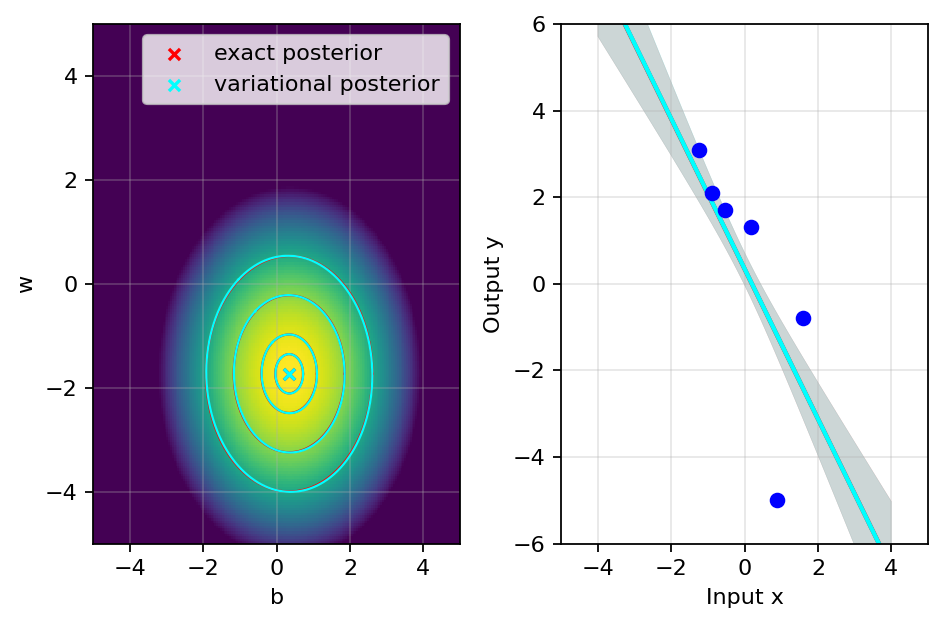

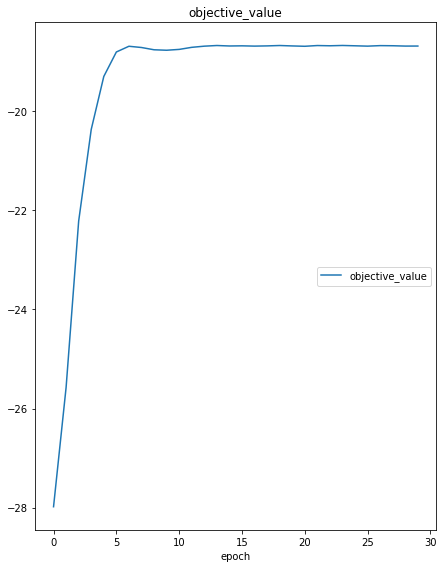

objective_value
	objective_value  	 (min:  -27.982, max:  -18.670, cur:  -18.682)


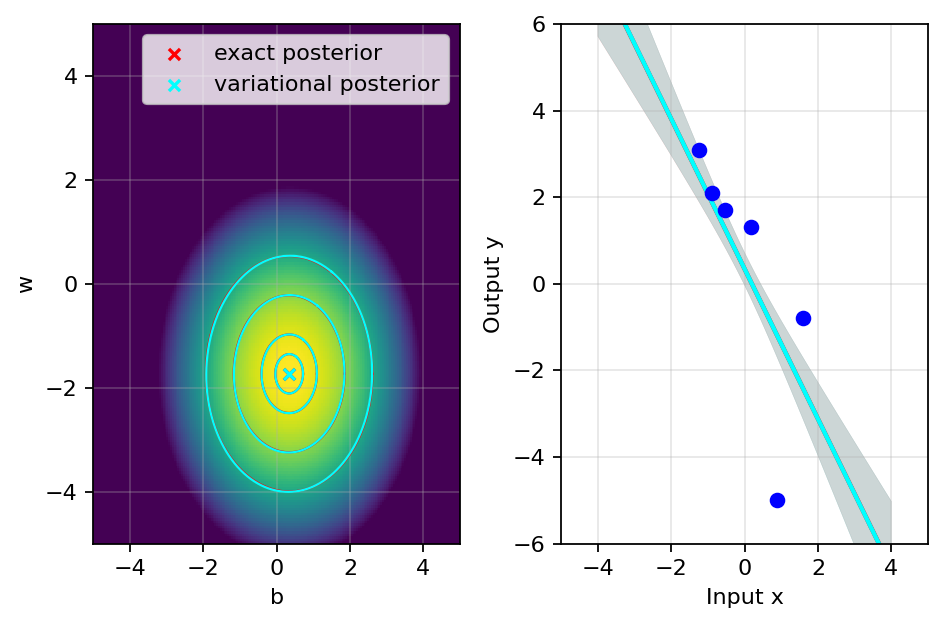

In [ ]:




Gaussian_ELBO = gen_Gaussian_ELBO(model=vmap_linear, alpha=alpha,
                                ll_func=gaussian_ll, Nsamples=1000)


params = initialize_params(D=2, key=random.PRNGKey(0))

objective = jit(partial(Gaussian_ELBO, X=affine_basis(x_data_list_outlier), y=y_data_list_outlier))


optimised_regularised_params = optimise(objective, params=params, \
                            plotting_func=gen_plots, LR=5e-3, MAX_STEPS=1500, LOG_EVERY=50)



      


**Group task** - Discuss with a neighbour and / or mentor:
* Can we overfit with this algorithm?
* Under what conditions does our variational inference algorithm recover the true posterior?




## Lets approximate the Logistic regression posterior with variational inference

Now that we have verified that our black box variational inference algorithm does the right thing, lets try to apply it for the logistic regression problem.

Now we are targettting a non-Gaussian posterior that is proportional to 

<center>
$p(\underline{y} | X, \color{blue}{\underline{w}}) p(\color{blue}{\underline{w}})  =  \prod_{n=1}^N Bern(y_n ; \phi(x_n \color{blue}{\underline{w}})) \mathcal{N}(\color{blue}{\underline{w}}; 0, \alpha^{-1} I)$
</center>

In [ ]:
#@title pre-compute loss surface and make plotting function

alpha = 1


def generate_loss_fun():
  def loss_fun(w):
    return logistic_regression_loss(X=affine_basis(x_data_list_classification),
                    y=y_data_list_classification, vmap_model=vmap_linear, w=w, alpha=alpha)
  return loss_fun
loss_fun = generate_loss_fun()

x0_grid, x1_grid, loss_grid = generate_loss_grid(loss_fun=loss_fun, grid_size=200, lim0=[-5,5], lim1=[-3,7])


def gen_plots(params):

    # Plot loss landscape and variational distribution
      q_covariance = get_Sig(params, min_diag=1e-6)
      q_mu = params['w']


      x_pred = np.linspace(-4, 4, 100)
      X_pred = affine_basis(x_pred)


      Nsamples = 20
      q_parameter_samples = jax.random.multivariate_normal(key, q_mu,  q_covariance, shape=(Nsamples,))
      q_sample_preds = vmap_linear(X_pred, q_parameter_samples.T)
      q_prob_samples = jax.nn.sigmoid(q_sample_preds)

      fig, ax = plt.subplots(1, 2, dpi=160)

      loss_landscape = ax[0].pcolormesh(x0_grid, x1_grid, -loss_grid,
                                vmin=-loss_grid.min() * 5, vmax=-loss_grid.min(),
                                cmap='viridis') # 

      plot_log_gaussian_ellipse(ax=ax[0], mean=q_mu, cov=q_covariance,
                                color='cyan', alpha=1, lw=1, label='variational posterior',
                                MAP_size=25, std_levels=[1, 2, 4, 6])
      ax[0].set_ylabel('w')
      ax[0].set_xlabel('b')
      ax[0].grid(alpha=0.3)
      ax[0].legend()
      ax[0].set_ylim([-3,7])
      ax[0].set_xlim([-5,5])


      ax[1].plot(x_pred, q_prob_samples, "-", color='cyan', lw=0.4, alpha=0.4)
      ax[1].plot(x_pred, q_prob_samples.mean(axis=1), "-", color='cyan', lw=2, label='variational posterior')

      mode_predictions = sigmoid(vmap_linear(affine_basis(x_pred), optimised_regularised_classification_params))
      ax[1].plot(x_pred, mode_predictions, c='red', label='regularised optimised solution')

      # Plot posterior predictive

      ax[1].plot(x_data_list_classification, y_data_list_classification, "ob")
      ax[1].set(xlabel="Input x", ylabel="Output y",
            xlim=xlim, ylim=[-0.1, 1.1])
      ax[1].grid(alpha=0.3)
      ax[1].legend()

      plt.tight_layout()




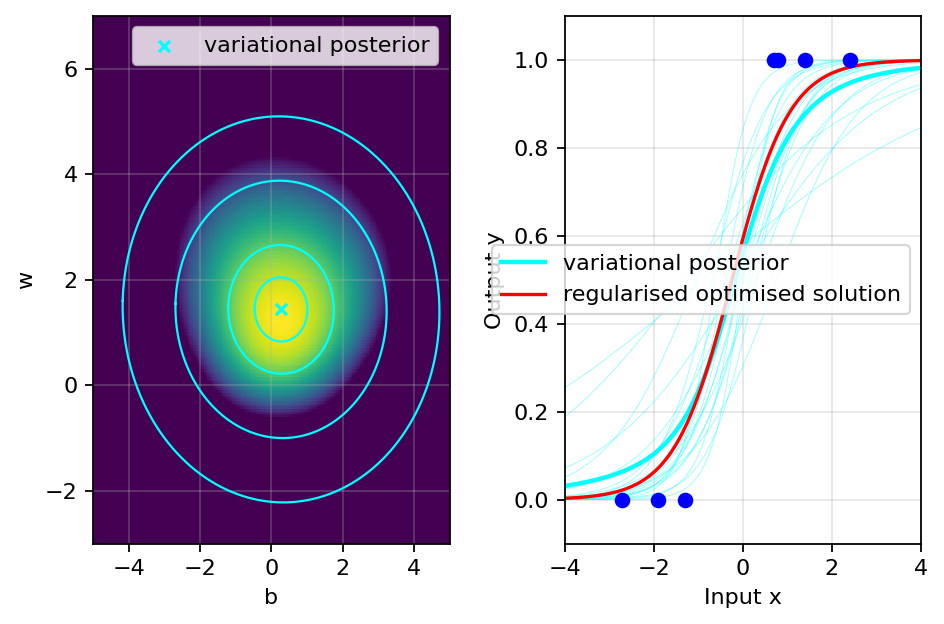

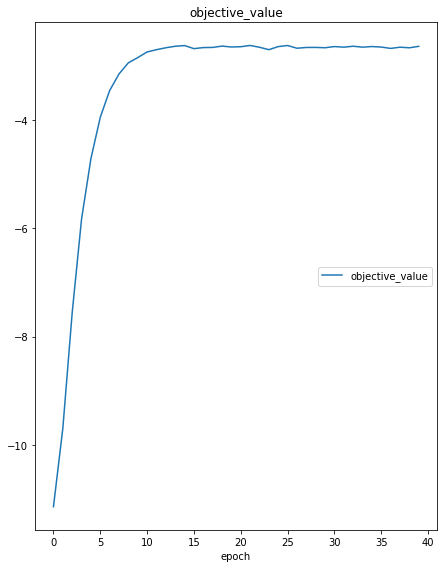

objective_value
	objective_value  	 (min:  -11.138, max:   -2.631, cur:   -2.647)


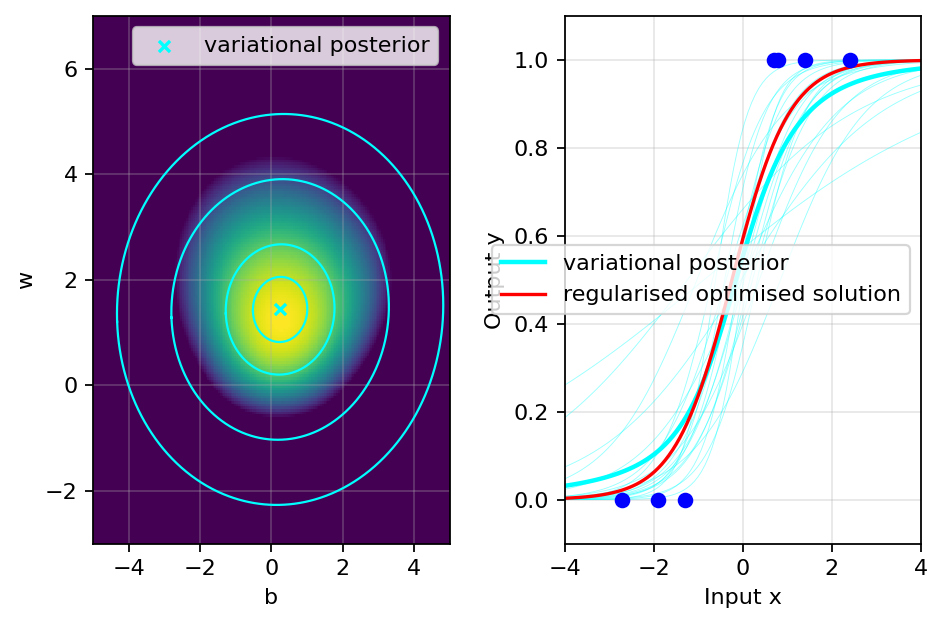

In [ ]:



Gaussian_ELBO = gen_Gaussian_ELBO(model=vmap_linear, alpha=alpha,
                                ll_func=bernouilli_ll, Nsamples=100) # Nottice we use the bernoulli likelihood now


params = initialize_params(D=2, key=random.PRNGKey(0))

objective = jit(partial(Gaussian_ELBO, X=affine_basis(x_data_list_classification), y=y_data_list_classification))


optimised_regularised_params = optimise(objective, params=params, \
                            plotting_func=gen_plots, LR=5e-3, MAX_STEPS=2000, LOG_EVERY=50)



**Group task** - Discuss with a neighbour and / or mentor:

* How many parameters are we learning?

* Are we reaching exact posterior?

* Potential drawbacks of this method?

* How does the Bayesian posterior predictive compare with the regularised optimisation solution? Is it more or less confident?

* Does it make sense to return standard deviation over probabilities? How do we combine information from samples?

## MNIST classification -- the mean field assumption (Optional) - <font color='orange'>`Intermediate`</font>


TODO

## The ELBO as a surrogate to the evidence for hyperparameter selection (Optional) - <font color='red'>`Advanced`</font>

TODO

# Section 4: A Bayesian Neural Network

In [ ]:
#@title Lets start with a very simple dataset, one that is very close to the indentity function $\,\,y=x$

x_data_list_identity = jnp.array([-2, -1.8, -1,  2, 2, 2.1]) 
y_data_list_identity = jnp.array([-2, -1.9, -1, 2, 1.9, 2.1]) 





In [ ]:
#@title Lets start with a very basic NN
#@markdown specifically $f(x, \color{blue}{\underline{w}}) = \color{blue}{\underline{w}_{1}} \color{blue}{\underline{w}_{0}} x$

def NN(x, params):
  return  params[1] * params[0] * x

vmap_NN = jit(vmap(NN, in_axes=(0, None)))

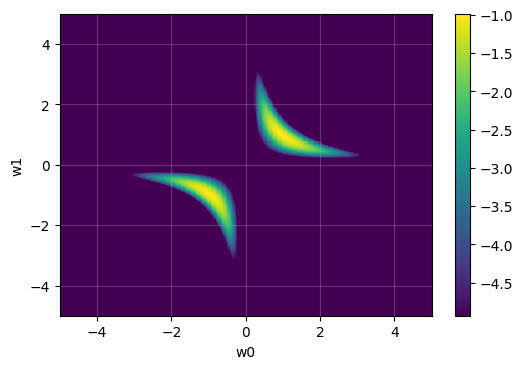

In [ ]:
#@title ## Plot the loss landscape. It is non-convex. Its multimodal! 
#@markdown (even though we are trying to learn a simple identity function)

#@markdown This is due to the symmetries in the weight space between  $\color{blue}{\underline{w}_{1}}$ and $\color{blue}{\underline{w}_{0}}$. You can flip these weights around and obtain the same solution!


alpha=1


def generate_loss_fun():
  def loss_fun(w):
    return regularised_linear_regression_loss(X=x_data_list_identity,
                    y=y_data_list_identity, w=w, vmap_model=vmap_NN, alpha=alpha)
  return loss_fun

loss_fun = generate_loss_fun()

x0_grid, x1_grid, loss_grid = generate_loss_grid(loss_fun=loss_fun, grid_size=300, lim0=[-5,5], lim1=[-5,5])

plt.figure(dpi=100)
loss_landscape = plt.pcolormesh(x0_grid, x1_grid, -loss_grid,
                          vmin=-loss_grid.min() * 5, vmax=-loss_grid.min(),
                          cmap='viridis') # 

plt.xlabel('w0')
plt.ylabel('w1')
plt.colorbar()
plt.grid(alpha=0.3)



## Our unimodal Gaussian approximation will struggle with the multimodal posterior but lets apply the black box variational inference algorithm anyway!

In [ ]:
#@title define plotting method

def gen_plots(params):
    # Plot loss landscape and variational distribution
    q_covariance = get_Sig(params, min_diag=1e-6)
    q_mu = params['w']

    fig, ax = plt.subplots(1, 2, dpi=160)

    loss_landscape = ax[0].pcolormesh(x0_grid, x1_grid, -loss_grid,
                              vmin=-loss_grid.min() * 5, vmax=-loss_grid.min(),
                              cmap='viridis') # 
    plot_log_gaussian_ellipse(ax=ax[0], mean=q_mu, cov=q_covariance,
                              color='cyan', alpha=1, lw=1, label='variational posterior',
                              MAP_size=25, std_levels=[1, 2, 4, 6])
    ax[0].set_ylabel('w')
    ax[0].set_xlabel('b')
    ax[0].grid(alpha=0.3)
    ax[0].legend()
    ax[0].set_ylim([-5,5])
    ax[0].set_xlim([-5,5])

    # Plot posterior predictive

    x_pred = np.linspace(-5, 5, 100)
    Nsamples = 20
    q_parameter_samples = jax.random.multivariate_normal(key, q_mu,  q_covariance, shape=(Nsamples,))
    q_sample_preds = vmap_NN(x_pred, q_parameter_samples.T)

    ax[1].plot(x_pred, q_sample_preds, c='cyan', alpha=0.7, lw=0.4)

    errorfill(x_pred, q_sample_preds.mean(axis=1), q_sample_preds.std(axis=1), color='cyan', alpha_fill=0.1, line_alpha=1, ax=ax[1],
                  lw=2, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='variational approx', markevery=None)


    ax[1].plot(x_data_list_identity, y_data_list_identity, "ob")
    ax[1].set(xlabel="Input x", ylabel="Output y",
          xlim=[-3,3], ylim=[-4,4])
    ax[1].grid(alpha=0.3)

    plt.tight_layout()


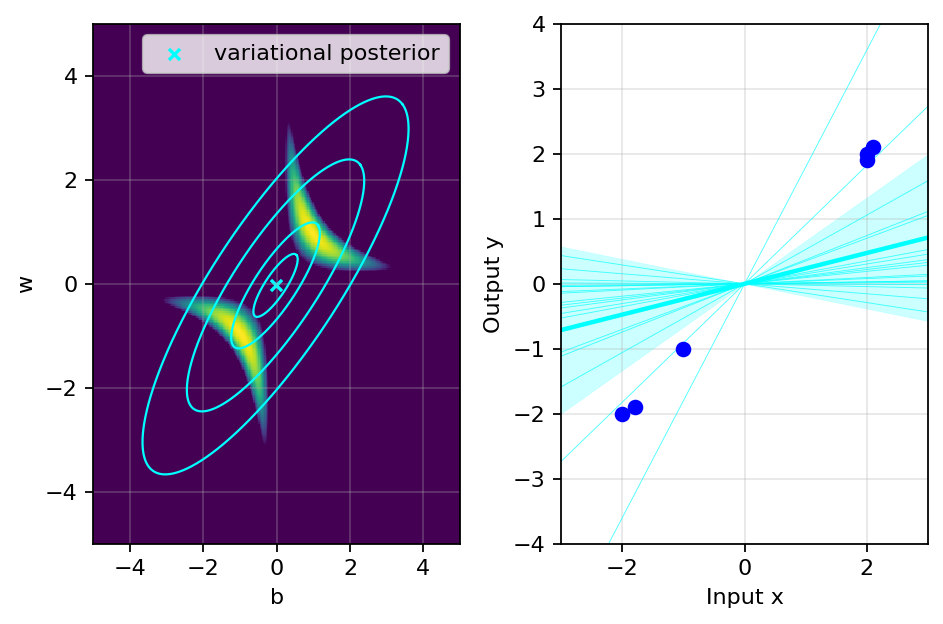

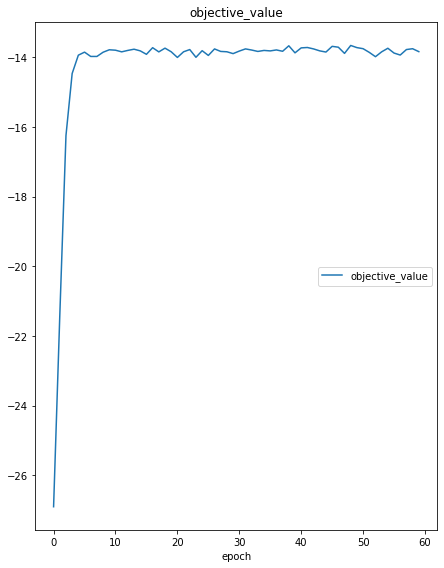

objective_value
	objective_value  	 (min:  -26.902, max:  -13.664, cur:  -13.841)


{'L': DeviceArray([[0.        , 0.        ],
              [0.51012385, 0.        ]], dtype=float32),
 'L_rho': DeviceArray([-0.49133512, -1.0716447 ], dtype=float32),
 'w': DeviceArray([-0.03420974, -0.03245936], dtype=float32)}

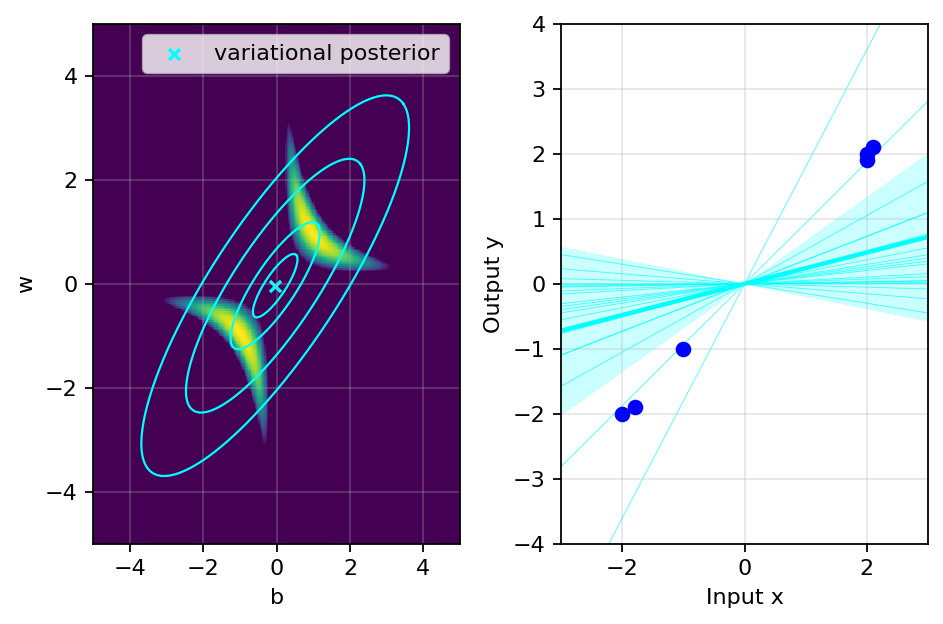

In [ ]:
#@title try setting `large_init` to both true and false and optimising. 
#@markdown What changes?

large_init = False
Gaussian_ELBO = gen_Gaussian_ELBO(model=vmap_NN, alpha=alpha,
                                ll_func=gaussian_ll, Nsamples=100)


params = initialize_params(D=2, key=random.PRNGKey(42))
if large_init:
  params['w'] = params['w'] * 5


objective = jit(partial(Gaussian_ELBO, X=x_data_list_identity, y=y_data_list_identity))


optimise(objective, params=params, \
            plotting_func=gen_plots, LR=5e-3, MAX_STEPS=2000, LOG_EVERY=50)





**Group task** - Discuss with a neighbour and / or mentor:
* Has your experimentation with the `large_init` option led you to discover a potential failure mode of our black box variational inference algorithm?

* When we do converge to one of the modes, does it matter which one we converge to? Are both the same?



## Exploring the limitations of Variational Inference for BNNs (Optional) - <font color='orange'>`Intermediate`</font>

Lets try a slightly more realistic example: a 4 parameter neural network complete with weights and biases. We will try to fit the same identity dataset.

In [ ]:
#@title Our NN is now $f(x, \color{blue}{\underline{w}}) = w_1 \text{ReLU}(w_0 x + b_0) + b_1$

def NN(x, params):
  return  params[2] * jax.nn.relu(x * params[0] + params[1]) + params[3]

vmap_NN = jit(vmap(NN, in_axes=(0, None)))




In [ ]:
#@title plot generation code

def gen_plots(params):
    # Plot loss landscape and variational distribution
    q_covariance = get_Sig(params, min_diag=1e-6)
    q_MAP = params['w']

    # Plot posterior predictive

    x_pred = np.linspace(-5, 5, 100)
    Nsamples = 20
    q_parameter_samples = jax.random.multivariate_normal(key, q_MAP,  q_covariance, shape=(Nsamples,))
    q_sample_preds = vmap_NN(x_pred, q_parameter_samples.T)

    plt.figure(dpi=100)
    plt.plot(x_pred, q_sample_preds, c='cyan', alpha=0.7, lw=0.4)

    ax = plt.gca()
    errorfill(x_pred, q_sample_preds.mean(axis=1), q_sample_preds.std(axis=1), color='cyan', alpha_fill=0.1, line_alpha=1, ax=ax,
                  lw=2, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='variational approx', markevery=None)


    ax.plot(x_data_list_identity, x_data_list_identity, "ob")
    
    ax.set(xlabel="Input x", ylabel="Output y",
          xlim=[-3,3], ylim=[-4,4])
    plt.grid(alpha=0.3)

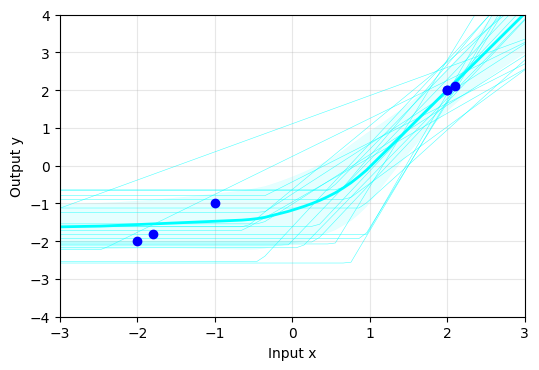

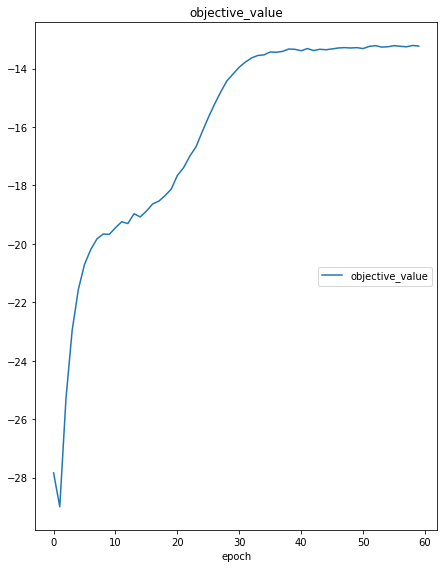

objective_value
	objective_value  	 (min:  -28.994, max:  -13.209, cur:  -13.230)


{'L': DeviceArray([[ 0.        ,  0.        ,  0.        ,  0.        ],
              [-0.9706476 ,  0.        ,  0.        ,  0.        ],
              [-0.06487291, -0.221495  ,  0.        ,  0.        ],
              [ 0.02594   , -0.16269639, -0.39304313,  0.        ]],            dtype=float32),
 'L_rho': DeviceArray([-0.48986033, -0.08442805, -1.4437745 , -0.9020866 ], dtype=float32),
 'w': DeviceArray([ 1.8859515, -0.5097865,  1.1070303, -1.5708326], dtype=float32)}

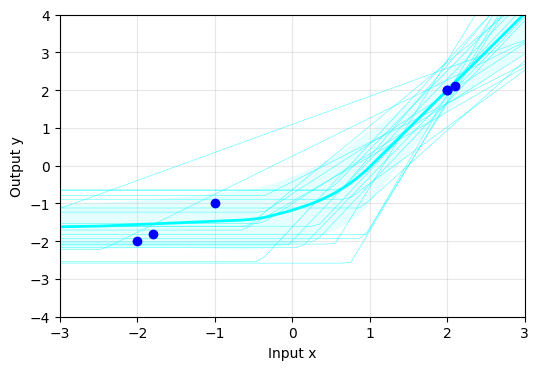

In [ ]:
#@title Optimise the variational parameters
#@markdown We cant plot the loss landscape anymore because it is 4 dimensional. But we can always plot the predictive posterior

#@markdown Try using different seeds: 0 and 42

alpha=0.1

Gaussian_ELBO = gen_Gaussian_ELBO(model=vmap_NN, alpha=alpha,
                                ll_func=gaussian_ll, Nsamples=100)


# params = initialize_params(D=4, key=random.PRNGKey(0))  # comment me
params = initialize_params(D=4, key=random.PRNGKey(42))  # uncomment me



objective = jit(partial(Gaussian_ELBO, X=x_data_list_identity, y=y_data_list_identity))

optimise(objective, params=params, \
            plotting_func=gen_plots, LR=2e-3, MAX_STEPS=3000, LOG_EVERY=50)




**Group task** - Discuss with a neighbour and / or mentor:

* How do the solutions found by the seeds 0 and 42 differ? What does this tell you about the loss landscape?

* Can you think up with a setting of the parameters ($b_0, w_0, b_1, w_1$) that recovers the identity?

* Why doesnt our optimiser find this configuration?

* Do the errorbars look reasonable?

* Do you think that our black box variational inference algorithm is a good tool for use with neural network models? How can it be improved?

# Section 5: Hamiltonian Monte Carlo (Optional) - <font color='red'>`Advanced`</font>

:Math foundations:


In [ ]:
import numpyro

ModuleNotFoundError: ignored

**Math Task:**

[Optional math task or ask multiple choice question. E.g. the derivation of this would equal a, b or c.]


In [ ]:
selection = 'a' #@param ["a", "b", "c"]
print(f"You selected: {selection}")

Code demonstration

In [ ]:
# Code demonstration

**Code Task:**

In [ ]:
# Code to be implemented during practical

## Conclusion
**Summary:**

[Summary of the main points/takeaways from the prac.]

**Next Steps:** 

[Next steps for people who have completed the prac, like optional reading (e.g. blogs, papers, courses, youtube videos). This could also link to other pracs.]

**Appendix:** 

[Anything (probably math heavy stuff) we don't have space for in the main practical sections.]

**References:** 

[References for any content used in the notebook.]

For other practicals from the Deep Learning Indaba, please visit [here](https://github.com/deep-learning-indaba/indaba-pracs-2022).

## Feedback

Please provide feedback that we can use to improve our practicals in the future.

In [ ]:
#@title Generate Feedback Form. (Run Cell)
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://forms.gle/bvLLPX74LMGrFefo9",
  width="80%" 
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />